**В этом ноутбуке выполнена часть задач с использованием SQL и подключением к PostgreSQL**


**Разделы ноутбука:**
1. Импорт библиотек и общие настройки.
2. SQL-запросы к Postresql, проверка ключевых полей, объединение таблиц и выгрузка в датафреймы и CSV, добавление простых фич и свод всей информации в один датафрейм.
3. Разаботка ТЗ: описание бизнеса и возможных бизнес-задач, анализ отсутствующей информации, предварительная черновая постановка задач исходя из описания бизнеса (дополнительные фичи, задачи машинного обучения, возможные идеи по диаграммам и т.д.)
4. Feature engineering: еще раз описание фич, их категоризация по методу исполнения. Основной блок - это создание фич на основе оконных функций (скользящее фиксированное окно и окно нарастающим итогом), которые позволяют сделать срез состояния показателей на момент создания нового заказа и при разработке моделей имитировать наличие только знания о фактах на момент события создания ордера.
5. Задачи машинного обучения. Первая - построение регрессионной модели прогнозирования дальнейших среднедневных продаж продукта после создания текущего заказа. Вторая - классификация и выявление потенциально неудовлетворенного клиента.
6. Диаграммы: визуализация отдельных моментов.
7. Итоги и выводы анализа.


# Импорт библиотек, общие настройки

In [1]:
import os
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import sql
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import re
from collections import Counter

In [2]:
import ipywidgets
from ipywidgets import interact, interact_manual, widgets, Button, DatePicker, Layout
from IPython.display import display, clear_output, HTML

In [3]:
import time
import datetime
from datetime import date
from pandas.tseries.offsets import DateOffset

In [4]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [5]:
import helper as h

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import re
import eli5

NumExpr defaulting to 2 threads.


In [154]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay

In [99]:
from tabulate import tabulate

In [8]:
PATH = "./data" # относительный путь к подпапке.
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [50]:
# Close communication with the database
cursor.close()
conn.close()

In [6]:
conn = psycopg2.connect("""
    host=-----
    port=6432
    dbname=olist
    user=----
    password=-----
    target_session_attrs=read-write
    sslmode=verify-full
""") 

In [7]:
print("Информация о сервере PostgreSQL")
print(conn.get_dsn_parameters(), "\n")

Информация о сервере PostgreSQL
{'user': 'user1', 'channel_binding': 'prefer', 'dbname': 'olist', 'host': 'rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net', 'port': '6432', 'tty': '', 'options': '', 'sslmode': 'verify-full', 'sslcompression': '0', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'read-write'} 



In [8]:
cursor = conn.cursor()

In [9]:
def refcon():
    global conn
    global cursor
    cursor.close()
    conn.close()
    conn = psycopg2.connect("""
        host=----
        port=6432
        dbname=olist
        user=----
        password=----
        target_session_attrs=read-write
        sslmode=verify-full
    """) 
    cursor = conn.cursor()

In [10]:
df_shema = pd.read_csv(os.path.join(PATH, 'chema.csv'), sep=';')

In [11]:
# список таблиц базы
list_of_tables=df_shema['table_name'].unique()

In [9]:
# Получение всех строк из всех таблиц
list_tables_for_upload=list_of_tables # ['geolocation']#,'sellers','products']
for item in list_tables_for_upload:
    query_txt="SELECT * FROM "+item+";"
    cursor.execute(query_txt)
    record = cursor.fetchall()
    print("Количество строк ", item,"- ", len(record))
    #print("Первое значение - ", record[0], "\n")
    #df1=pd.DataFrame(list(record), columns=list(df_shema[df_shema['table_name']==item]['column_name']))
    #df1.to_csv(os.path.join(PATH, item+'.csv'), sep=';', header=True, index=False)

Количество строк  closed_deals -  842
Количество строк  customers -  99441
Количество строк  geolocation -  1000163
Количество строк  marketing_qualified_leads -  8000
Количество строк  order_items -  112650
Количество строк  order_payments -  103886
Количество строк  order_reviews -  99224
Количество строк  orders -  99441
Количество строк  products -  32951
Количество строк  sellers -  3095


# Блок с SQL-запросами к базе данных

- выгружаем из базы уже соединенные три основных датасета в датафреймы Pandas. И далее работаем уже с Pandas

## Функция реализации запроса к базе

In [12]:
# функция для выполнения SQL-запроса и создания датафрейма
def sql_full(sql_text):
    try:
        #print(sql_text)
        cursor.execute(sql_text)
        tmp = cursor.fetchall()
        col_names = []
        for item in cursor.description:
            col_names.append(item[0])
        df = pd.DataFrame(tmp, columns=col_names)
        return [col_names]+tmp, df
    except Exception:
        print('Ошибка в функции выполнения SQL-запроса')  
        #print(sql_text)
        refcon()
        return 'НЕТ', pd.DataFrame(columns = ['in'])

In [11]:
# шаблон настраиваемого SQL-запроса с получением списка полей и созданием датафрейма pandas (пример)
columns_customers = ('customer_unique_id', 'customer_zip_code_prefix', 'customer_city')
table_base='customers'
stmt = sql.SQL('SELECT {} FROM {} LIMIT 5').format(
            sql.SQL(',').join(map(sql.Identifier, columns_customers)),
            sql.Identifier('customers')
        )
cursor.execute(stmt)
tmp = cursor.fetchall()
col_names = []
for item in cursor.description:
    col_names.append(item[0])
dftest152 = pd.DataFrame(tmp, columns=col_names)
dftest152.head()

,customer_unique_id,customer_zip_code_prefix,customer_city
0,861eff4711a542e4b93843c6dd7febb0,14409,franca
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas


## Денормализация таблиц

'closed_deals', 'customers', 'geolocation', 'marketing_qualified_leads', 'order_items', 'order_payments', 'order_reviews', 'orders', 'products', 'sellers', 'product_category_name_translation'



### Проверяем наличие уникальных ключей в таблицах

In [13]:
query_txt="""
SELECT
  COUNT(DISTINCT mql_id) num_MQlead,
  COUNT(DISTINCT landing_page_id) num_landingpage,
  COUNT(DISTINCT origin) num_origin,
  COUNT(*) totalRows
FROM
  marketing_qualified_leads;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_mqlead,num_landingpage,num_origin,totalrows
0,8000,495,10,8000


In [13]:
query_txt="""
SELECT
  COUNT(DISTINCT mql_id) num_MQlead,
  COUNT(DISTINCT seller_id) num_Seller,
  COUNT(DISTINCT sdr_id) num_SalesSV,
  COUNT(DISTINCT sr_id) num_SalesTA,
  COUNT(*) totalRows
FROM
  closed_deals;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_mqlead,num_seller,num_salessv,num_salesta,totalrows
0,842,842,32,22,842


In [14]:
query_txt="""
SELECT
  COUNT(DISTINCT order_id) num_Orders,
  COUNT(DISTINCT customer_id) num_CustomersNonUnique,
  COUNT(*) totalRows
FROM
  orders;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_orders,num_customersnonunique,totalrows
0,99441,99441,99441


In [15]:
query_txt="""
SELECT
  COUNT(DISTINCT customer_id) num_CustomersNonUnique,
  COUNT(DISTINCT customer_unique_id) num_CustomersUnique,
  COUNT(DISTINCT customer_zip_code_prefix) num_zipcode,
  COUNT(DISTINCT customer_city) num_city,
  COUNT(*) totalRows
FROM
  customers;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_customersnonunique,num_customersunique,num_zipcode,num_city,totalrows
0,99441,96096,14994,4119,99441


**В order_reviews нет уникального ключа**

In [16]:
query_txt="""
SELECT
  COUNT(DISTINCT review_id) num_review,
  COUNT(DISTINCT order_id) num_order,
  COUNT(DISTINCT review_comment_title) num_title,
  COUNT(DISTINCT review_comment_message) num_message,
  COUNT(*) totalRows
FROM
  order_reviews;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_review,num_order,num_title,num_message,totalrows
0,98410,98673,4525,36159,99224


In [17]:
query_txt="""
SELECT
  COUNT(DISTINCT order_id) num_order,
  COUNT(DISTINCT payment_sequential) num_payment_sequential,
  COUNT(DISTINCT payment_type) num_payment_type,
  COUNT(DISTINCT payment_installments) num_payment_installments,
  COUNT(*) totalRows
FROM
  order_payments;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_order,num_payment_sequential,num_payment_type,num_payment_installments,totalrows
0,99440,29,5,24,103886


In [18]:
query_txt="""
SELECT
  COUNT(DISTINCT order_item_id) num_order_item,
  COUNT(DISTINCT order_id) num_order,
  COUNT(DISTINCT product_id) num_product,
  COUNT(DISTINCT seller_id) num_seller,
  COUNT(*) totalRows
FROM
  order_items;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_order_item,num_order,num_product,num_seller,totalrows
0,21,98666,32951,3095,112650


In [19]:
query_txt="""
SELECT
  COUNT(DISTINCT product_id) num_product,
  COUNT(DISTINCT product_category_name) num_product_category_name,
  COUNT(*) totalRows
FROM
  products;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_product,num_product_category_name,totalrows
0,32951,74,32951


In [178]:
query_txt="""
SELECT
  COUNT(DISTINCT seller_id) num_seller,
  COUNT(DISTINCT seller_zip_code_prefix) num_seller_zip_code,
  COUNT(DISTINCT seller_state) num_seller_state,
  COUNT(DISTINCT seller_city) num_seller_city,
  COUNT(*) totalRows
FROM
  sellers;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_seller,num_seller_zip_code,num_seller_state,num_seller_city,totalrows
0,3095,2246,23,611,3095


In [21]:
query_txt="""
SELECT
  COUNT(DISTINCT geolocation_zip_code_prefix) num_geolocation_zip_code,
  COUNT(DISTINCT geolocation_city) num_geolocation_city,
  COUNT(DISTINCT geolocation_state) num_geolocation_state,
  COUNT(*) totalRows
FROM
  geolocation;
"""
q_txt, q_pandas = sql_full(query_txt)
q_pandas.head()

,num_geolocation_zip_code,num_geolocation_city,num_geolocation_state,totalrows
0,19015,7987,27,1000163


### Объединяем таблицы

#### Загружаем данные обработки текста отзывов в Google API

In [14]:
df_api = pd.read_csv(os.path.join(PATH, 'order_reviews_only_Google_all.csv'), sep=';')

In [15]:
df_api.head(2)

,review_id,order_id,sent_score,sent_magnitude,entities_list,sentences_count,token_count,sentlist,tokenlist
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Orders_reviews. Запрашиваем и присоединеняем результат обработки API

In [16]:
query_txt="""
SELECT *
FROM order_reviews;
"""
q_txt, q_pandas = sql_full(query_txt)
print(q_pandas.shape)
q_pandas.head()

(99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01,2018-03-02 10:26:53


In [17]:

df_order_reviews=pd.merge(q_pandas, df_api.rename(columns={'review_id': 'api_review_id','order_id':'api_order_id'}),  
         how='left', left_on=['review_id','order_id'], right_on = ['api_review_id','api_order_id']).drop(['api_review_id','api_order_id'], axis=1)
print('order_reviews:',df_order_reviews.shape)

order_reviews: (99224, 14)


In [18]:
df_order_reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sent_score,sent_magnitude,entities_list,sentences_count,token_count,sentlist,tokenlist
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### ORDER_Items расширенный

In [19]:
query_txt_closed_deals="""
SELECT '' || STRING_AGG('o.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'closed_deals'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('seller_id');
"""
q_txt_closed_deals, q_pandas = sql_full(query_txt_closed_deals)

query_txt_order_items="""
SELECT '' || STRING_AGG('ord.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'order_items'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('seller_id');
"""
q_txt_order_items, q_pandas = sql_full(query_txt_order_items)

query_txt_products="""
SELECT '' || STRING_AGG('p.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'products'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('product_id');
"""
q_txt_products, q_pandas = sql_full(query_txt_products)

query_txt=f"""
WITH geoavg AS (SELECT 
  geolocation_zip_code_prefix,
  AVG(geolocation_lat) AS lat,
  AVG(geolocation_lng) AS lng
FROM geolocation
GROUP BY
    geolocation_zip_code_prefix),  

selzip AS (
SELECT 
    s.*, 
    geoavg.lat AS sellers_geo_lat,
    geoavg.lng AS sellers_geo_lng
FROM sellers s LEFT JOIN geoavg ON s.seller_zip_code_prefix=geoavg.geolocation_zip_code_prefix),

selzipclose AS (
SELECT 
    s.*, 
    {q_txt_closed_deals[1][0]}
FROM selzip s LEFT JOIN closed_deals o ON s.seller_id=o.seller_id),


oit AS (SELECT 
    {q_txt_order_items[1][0]}, 
    s.* 
FROM order_items ord LEFT JOIN selzipclose s ON ord.seller_id=s.seller_id)

SELECT
    oit.*, 
    {q_txt_products[1][0]}
FROM oit LEFT JOIN products p ON oit.product_id=p.product_id;
"""
#print(query_txt)
q_txt, df_order_items = sql_full(query_txt)
print(df_order_items.shape)
df_order_items.head(1)

(112650, 33)


,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0


#### ORDERS расширенный

In [20]:
query_txt_closed_deals="""
SELECT '' || STRING_AGG('o.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'closed_deals'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('seller_id');
"""
q_txt_closed_deals, q_pandas = sql_full(query_txt_closed_deals)
#print(q_txt_closed_deals)

query_txt_order_items="""
SELECT '' || STRING_AGG('ord.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'order_items'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('seller_id');
"""
q_txt_order_items, q_pandas = sql_full(query_txt_order_items)
#print(q_txt_order_items)

query_txt_products="""
SELECT '' || STRING_AGG('p.' || column_name, ', ') || ''
FROM information_schema.columns
WHERE table_name = 'products'
AND table_schema NOT IN ('information_schema','pg_catalog')
AND column_name NOT IN ('product_id');
"""
q_txt_products, q_pandas = sql_full(query_txt_products)
#print(q_txt_products)

q_txt_ordcustgeo="c.customer_unique_id, c.customer_zip_code_prefix, c.customer_city, c.customer_state, c.customers_geo_lat, c.customers_geo_lng"
#print(q_txt_ordcustgeo)

q_txt_rev="""rev.num_reviews_per_order, rev.min_review_create_date, rev.max_review_create_date, rev.min_review_answer_date, 
rev.max_review_answer_date, rev.review_id, rev.review_score"""

query_txt=f"""
WITH geoavg AS (SELECT 
  geolocation_zip_code_prefix,
  AVG(geolocation_lat) AS lat,
  AVG(geolocation_lng) AS lng
FROM geolocation
GROUP BY
    geolocation_zip_code_prefix),  

selzip AS (
SELECT 
    s.*, 
    geoavg.lat AS sellers_geo_lat,
    geoavg.lng AS sellers_geo_lng
FROM sellers s LEFT JOIN geoavg ON s.seller_zip_code_prefix=geoavg.geolocation_zip_code_prefix),

selzipclose AS (
SELECT 
    s.*, 
    {q_txt_closed_deals[1][0]}
FROM selzip s LEFT JOIN closed_deals o ON s.seller_id=o.seller_id),


oit AS (SELECT 
    {q_txt_order_items[1][0]}, 
    s.* 
FROM order_items ord LEFT JOIN selzipclose s ON ord.seller_id=s.seller_id),

order_items1 AS (SELECT
    oit.*, 
    {q_txt_products[1][0]}
FROM oit LEFT JOIN products p ON oit.product_id=p.product_id),


custgeo AS (
SELECT 
    c.*, 
    geoavg.lat AS customers_geo_lat,
    geoavg.lng AS customers_geo_lng
FROM customers c LEFT JOIN geoavg ON c.customer_zip_code_prefix=geoavg.geolocation_zip_code_prefix),

ordcustgeo AS (
SELECT
    ord.*, 
    {q_txt_ordcustgeo}
FROM orders ord LEFT JOIN custgeo c ON ord.customer_id=c.customer_id),

itemavg AS (SELECT 
  order_id,
  MAX(order_item_id) AS order_item_count,
  SUM(price) AS sum_price,
  SUM(freight_value) AS sum_freight_value,
  SUM(price)+SUM(freight_value) AS sum_price_freight

FROM order_items1
GROUP BY
    order_id),  

orditem1 AS (
SELECT 
    o.*, 
    i.order_item_count, i.sum_price, i.sum_freight_value, i.sum_price_freight
FROM ordcustgeo o LEFT JOIN itemavg i ON o.order_id=i.order_id),

ordprod AS (
SELECT 
  COUNT(*) as num_prod,
  order_id,
  product_id
FROM order_items1

GROUP BY
  order_id, 
  product_id),
  
unprod AS(
SELECT 
  COUNT(*) as num_uniq_prod,
  order_id
FROM ordprod

GROUP BY
  order_id),

orditem2 AS (
SELECT 
    o.*, 
    unprod.num_uniq_prod
FROM orditem1 o LEFT JOIN unprod ON o.order_id=unprod.order_id),

tmp AS (
SELECT 
  MAX(review_answer_timestamp) as max_review_answer_date,
  order_id
FROM order_reviews
GROUP BY
  order_id),
 
score AS( 
SELECT 
  s.review_score AS review_score,
  s.review_id AS review_id,
  s.review_answer_timestamp AS review_answer_timestamp,
  s.order_id AS order_id
FROM order_reviews s RIGHT JOIN tmp ON s.review_answer_timestamp=tmp.max_review_answer_date AND s.order_id=tmp.order_id),

avgr AS(
SELECT 
  order_id,
  COUNT(*) as num_reviews_per_order,
  MIN(review_creation_date) as min_review_create_date,
  MAX(review_creation_date) as max_review_create_date,
  MIN(review_answer_timestamp) as min_review_answer_date,
  MAX(review_answer_timestamp) as max_review_answer_date

  
FROM order_reviews

GROUP BY
  order_id),
  
rev AS (
SELECT 
a.*,
score.review_id AS review_id,
score.review_score
FROM avgr a LEFT JOIN score ON a.order_id=score.order_id)

SELECT 
    s.*,
    {q_txt_rev}
FROM orditem2 s LEFT JOIN rev ON s.order_id=rev.order_id;

"""
#print(query_txt)
q_txt, df_orders = sql_full(query_txt)
print(df_orders.shape)
df_orders.head(1)

(99441, 26)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score
0,543ab3128139efe78bf5e8006ae25087,ab2ea0f54206e58856bd5b50647a5cbf,delivered,2018-02-28 22:42:01,2018-02-28 22:50:29,2018-03-02 00:15:04,2018-04-02 14:09:00,2018-03-19,1b1e1338111f49fa2d7d5acf5fae5de1,1210,sao paulo,SP,-23.540039,-46.642091,1.0,510.0,70.44,580.44,1.0,1.0,2018-03-21,2018-03-21,2018-03-21 09:36:01,2018-03-21 09:36:01,00397dc753e8c52a2dd4d73a20b88ae7,1.0


#### Сохраняем в CSV-файлы для возможности резервного чтения при недоступности базы

In [216]:
df_order_reviews.to_csv(os.path.join(PATH, 'sql_order_reviews1.csv'), sep=';', header=True, index=False)
df_order_reviews.to_csv(os.path.join(PATH, 'sql_order_reviews2.csv'), sep='|', header=True, index=False)
df_order_items.to_csv(os.path.join(PATH, 'sql_order_items1.csv'), sep=';', header=True, index=False)
df_order_items.to_csv(os.path.join(PATH, 'sql_order_items2.csv'), sep='|', header=True, index=False)
df_orders.to_csv(os.path.join(PATH, 'sql_orders1.csv'), sep=';', header=True, index=False)
df_orders.to_csv(os.path.join(PATH, 'sql_orders2.csv'), sep='|', header=True, index=False)

#### Завершаю первый этап объединения исходных датасетов

In [21]:
df_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score
0,543ab3128139efe78bf5e8006ae25087,ab2ea0f54206e58856bd5b50647a5cbf,delivered,2018-02-28 22:42:01,2018-02-28 22:50:29,2018-03-02 00:15:04,2018-04-02 14:09:00,2018-03-19,1b1e1338111f49fa2d7d5acf5fae5de1,1210,sao paulo,SP,-23.540039,-46.642091,1.0,510.0,70.44,580.44,1.0,1.0,2018-03-21,2018-03-21,2018-03-21 09:36:01,2018-03-21 09:36:01,00397dc753e8c52a2dd4d73a20b88ae7,1.0


In [22]:
df_order_reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sent_score,sent_magnitude,entities_list,sentences_count,token_count,sentlist,tokenlist
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_order_items.head(1)

,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0


In [24]:
print(df_orders.shape)

(99441, 26)


In [25]:
tmp=df_order_reviews.groupby(['order_id']).agg({'review_answer_timestamp':'max'}).reset_index()
print(tmp.shape)
tmp.head(1)

(98673, 2)


,order_id,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-22 10:57:03


In [26]:
sl=['api_review_answer_timestamp','review_comment_title','review_comment_message','tokenlist','sentlist','entities_list',
    'api_order_id','review_answer_timestamp','review_id','review_score','review_creation_date']
score1=pd.merge(tmp, df_order_reviews.rename(columns={'review_answer_timestamp': 'api_review_answer_timestamp','order_id':'api_order_id'}),  
         how='left', left_on=['review_answer_timestamp','order_id'], 
                right_on = ['api_review_answer_timestamp','api_order_id']).drop(sl, axis=1)
score1.rename(columns={'order_id': 'api_order_id',}, inplace=True)
print('score1:',score1.shape)
score1.head(1)

score1: (98673, 5)


,api_order_id,sent_score,sent_magnitude,sentences_count,token_count
0,00010242fe8c5a6d1ba2dd792cb16214,0.9,0.9,1.0,8.0


In [27]:
df_orders_score=pd.merge(df_orders, score1, how='left', left_on=['order_id'], right_on=['api_order_id']).drop(['api_order_id'], axis=1)
print('df_orders_score:',df_orders_score.shape)
df_orders_score.head(1)

df_orders_score: (99441, 30)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count
0,543ab3128139efe78bf5e8006ae25087,ab2ea0f54206e58856bd5b50647a5cbf,delivered,2018-02-28 22:42:01,2018-02-28 22:50:29,2018-03-02 00:15:04,2018-04-02 14:09:00,2018-03-19,1b1e1338111f49fa2d7d5acf5fae5de1,1210,sao paulo,SP,-23.540039,-46.642091,1.0,510.0,70.44,580.44,1.0,1.0,2018-03-21,2018-03-21,2018-03-21 09:36:01,2018-03-21 09:36:01,00397dc753e8c52a2dd4d73a20b88ae7,1.0,-0.8,0.8,1.0,4.0


In [28]:
print(df_order_items.shape)

(112650, 33)


In [29]:
df_base=pd.merge(df_order_items, df_orders_score.rename(columns={'order_id':'api_order_id'}),
                 how='left', left_on=['order_id'], right_on=['api_order_id']).drop(['api_order_id'], axis=1)
print('df_base:',df_base.shape)
df_base.head(1)

df_base: (112650, 62)


,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870305,-44.593326,1.0,199.0,17.87,216.87,1.0,1.0,2018-01-23,2018-01-23,2018-01-23 16:06:31,2018-01-23 16:06:31,0c5b33dea94867d1ac402749e5438e8b,5.0,0.9,1.9,2.0,15.0


In [30]:
tmp2 = pd.read_csv(os.path.join(PATH, 'marketing_qualified_leads.csv'), sep=';')
print('tmp2e:',tmp2.shape)
tmp2.head(1)

tmp2e: (8000, 4)


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social


#### Это финальный объединенный датафрейм, сведеннный из всех остальных. 

In [31]:
df_base=pd.merge(df_base, tmp2.rename(columns={'mql_id':'api_mql_id'}),
                 how='left', left_on=['mql_id'], right_on=['api_mql_id']).drop(['api_mql_id'], axis=1)
print('df_base:',df_base.shape)
df_base.head(1)

df_base: (112650, 65)


,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count,first_contact_date,landing_page_id,origin
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870305,-44.593326,1.0,199.0,17.87,216.87,1.0,1.0,2018-01-23,2018-01-23,2018-01-23 16:06:31,2018-01-23 16:06:31,0c5b33dea94867d1ac402749e5438e8b,5.0,0.9,1.9,2.0,15.0,NaN,NaN,NaN


#### Добавление простых фич

In [453]:
#- общая сумма товара по строке заказа с учетом стоимости фрахта price+freight_value=price_freight_value
df_base['price_freight_value']=df_base['price']+df_base['freight_value']
#- расстояние между одной точкой координат и второй (желательно как функция геосистемы)

#- order_approved_at - order_purchase_timestamp = время между созданием заказа и подтверждением платежа, в часах
df_base['t_approved']=(df_base["order_approved_at"]-df_base["order_purchase_timestamp"]).dt.days*24+\
    ((df_base["order_approved_at"]-df_base["order_purchase_timestamp"]).dt.seconds //60)/60
#- order_delivered_carrier_date - order_purchase_timestamp - время на логистическую обработку (до момента отправки заказа клиенту), дней
df_base['t_logist_warehouse']=(df_base["order_delivered_carrier_date"]-df_base["order_purchase_timestamp"]).dt.days
#- order_delivered_customer_date - order_purchase_timestamp - время фактического выполнения заказа, дней
df_base['t_logist_fact']=(df_base["order_delivered_customer_date"]-df_base["order_purchase_timestamp"]).dt.days
#- order_estimated_delivery_date - order_purchase_timestamp - время декларируемого маркетплейсом времени поставки (формируют ожидания клиента), дней
df_base['t_logist_estimated']=(df_base["order_estimated_delivery_date"]-df_base["order_purchase_timestamp"]).dt.days
#- order_delivered_customer_date - order_delivered_carrier_date - затраты времени на доставку, часов и дней
df_base['t_logist_transport_days']=(df_base["order_delivered_customer_date"]-df_base["order_delivered_carrier_date"]).dt.days
df_base['t_logist_transport_hours']=(df_base["order_delivered_customer_date"]-df_base["order_delivered_carrier_date"]).dt.days*24+\
    ((df_base["order_delivered_customer_date"]-df_base["order_delivered_carrier_date"]).dt.seconds //60)/60

#- затраты времени на доставку / расстояние маршрута в км - некая условная величина, если по маршруту она резко ниже, то есть проблемы на стороне логистич оператора, часов/км

#- order_estimated_delivery_date - order_delivered_customer_date - задержка (-) доставки заказа или более ранняя доставка (+), дней
df_base['t_delay']=(df_base["order_estimated_delivery_date"]-df_base["order_delivered_customer_date"]).dt.days
#- аналогичный предыдущему, только при поставке раньше срока ставим +1
df_base['t_delay_negative']=np.where(df_base['t_delay']<0,df_base['t_delay'],1)
#- категория статуса нарушения срока доставки: 1-доставлено с опозданием, 0-доставлено без опоздания или раньше. критерий - предыдущий показатель
df_base['status_delay']=np.where(df_base['t_delay']<0 ,1,0)
#- - для остальных статусов - отдельная фича: отмененный заказ-1, иначе 0
df_base['status_cancelled']=np.where(df_base['order_status']!='delivered',1,0)
 
#- min_review_create_date - order_delivered_customer_date - через какое время после фактической доставки поступил запрос клиенту на опрос удовлетворенности 
#(если доставлен товар вовремя, то должен быть через 1 день, округляем до дней, должно быть 0), дней
df_base['t_review_create_delivered']=(df_base["min_review_create_date"]-df_base["order_delivered_customer_date"]).dt.days
#- min_review_create_date - order_estimated_delivery_date - через какое время после ожидаемой доставки поступил запрос клиенту на опрос удовлетворенности 
#(если товар доставлен вовремя или раньше, то значение максимум будет 1), дней
df_base['t_review_create_estimated']=(df_base["min_review_create_date"]-df_base["order_estimated_delivery_date"]).dt.days
#- min_review_answer_date - min_review_create_date - время реакции клиента на первый запрос, в часах
df_base['t_answer_first']=(df_base["min_review_answer_date"]-df_base["min_review_create_date"]).dt.days*24+\
    ((df_base["min_review_answer_date"]-df_base["min_review_create_date"]).dt.seconds //60)/60
#- max_review_answer_date - max_review_create_date - время реакции клиента на последний запрос, в часах (если был только один опрос, то будет совпадать с предыдущим показателем)
df_base['t_answer_last']=(df_base["max_review_answer_date"]-df_base["max_review_create_date"]).dt.days*24+\
    ((df_base["max_review_answer_date"]-df_base["max_review_create_date"]).dt.seconds //60)/60
#- max_review_answer_date - min_review_create_date - общее время взаимодействия с клиентом при наличии нескольких опросов, в часах
df_base['t_answer_all']=(df_base["max_review_answer_date"]-df_base["min_review_create_date"]).dt.days*24+\
    ((df_base["max_review_answer_date"]-df_base["min_review_create_date"]).dt.seconds //60)/60
#- won_date-first_contact_date - период закрытия сделки по новым лидам, дней
 
#- - неудовлетворенный клиент (1,0) - 1 ставим при наличии хотя бы одного из факторов: 
# наличие плохой оценки (1 или 2), наличие текстового комментария с тональностью менее 0
df_base['client_not_happy']=np.where(df_base['review_score']<3,1, np.where(df_base['sent_score']<0 ,1,0))
# плохая оценка
df_base['review_score_bad']=np.where(df_base['review_score']<3,1, 0)
# хорошая оценка
df_base['review_score_good']=np.where(df_base['review_score']>3,1, 0)
# есть текстовый отзыв
df_base['review_message_is']=np.where(pd.isna(df_base['sentences_count'])==True,0, 1)
# есть негативный текстовой отзыв
df_base['review_message_is_bad']=np.where(df_base['sent_score']<0,1, 0)

In [454]:
df_base.head(1)

,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count,first_contact_date,landing_page_id,origin,price_freight_value,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,t_answer_first,t_answer_last,t_answer_all,status_delay,status_cancelled,t_review_create_delivered,t_review_create_estimated,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870305,-44.593326,1.0,199.0,17.87,216.87,1.0,1.0,2018-01-23,2018-01-23,2018-01-23 16:06:31,2018-01-23 16:06:31,0c5b33dea94867d1ac402749e5438e8b,5.0,0.9,1.9,2.0,15.0,NaN,NaN,NaN,216.87,0.233333,1.0,7.0,21,6.0,144.7,13.0,1.0,16.1,16.1,16.1,0,0,0.0,-13.0,0,0,1,1,0


In [378]:
df_base[df_base['sent_score']<0].head(2)

,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count,first_contact_date,landing_page_id,origin,price_freight_value,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,t_answer_first,t_answer_last,t_answer_all,status_delay,status_cancelled,t_review_create_delivered,t_review_create_estimated,client_not_happy
3,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,2018-03-26 18:31:29,145.95,11.65,a416b6a846a11724393025641d4edd5e,3702,sao paulo,SP,-23.515978,-46.547372,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,beleza_saude,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.954600,-46.337731,1.0,145.95,11.65,157.6,1.0,1.0,2018-03-30,2018-03-30,2018-04-02 00:52:01,2018-04-02 00:52:01,67b1ab8f3ec19d5a90f153f21757d3a1,1.0,-0.2,0.5,2.0,32.0,NaN,NaN,NaN,157.6,23.9,8.0,9.0,9,1.0,41.650000,-1.0,-1.0,72.866667,72.866667,72.866667,1,0,0.0,1.0,1
31,001e7cf2ad6bef3ade12ebc56ceaf0f3,1,bdcf6a834e8faa30dac3886c7a58e92e,2018-05-22 10:59:50,35.90,15.20,2a84855fd20af891be03bc5924d2b453,30111,belo horizonte,MG,-19.917826,-43.942418,None,None,None,NaT,None,None,None,None,None,None,None,None,NaN,beleza_saude,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,d1684ed69f8fd574b7c344de923f379a,delivered,2018-05-19 10:29:23,2018-05-19 10:59:50,2018-05-21 14:34:00,2018-06-04 18:08:23,2018-06-05,43860f86362fea12550bfa19ef73015f,38550,coromandel,MG,-18.476274,-47.196821,1.0,35.90,15.20,51.1,1.0,1.0,2018-06-05,2018-06-05,2018-06-06 19:01:54,2018-06-06 19:01:54,048baba3f11436d12b06dab572aafc21,1.0,-0.8,1.6,2.0,8.0,NaN,NaN,NaN,51.1,0.5,2.0,16.0,16,14.0,339.566667,0.0,1.0,43.016667,43.016667,43.016667,0,0,0.0,0.0,1


In [296]:
df_base.to_csv(os.path.join(PATH, 'df_base.csv'), sep=';', header=True, index=False)

In [212]:
df_base = pd.read_csv(os.path.join(PATH, 'df_base.csv'), sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Разработка ТЗ на фичи, диаграммы и задачи машинного обучения (исходя из описания бизнес-задачи)

## Путь покупателя на маркетплейсе. Возникновение Потребности

1. У покупателя возникает потребность в покупке и он решает ее реализовать с использованием данного маркетплейса. На выбор именно этой площадки влияет много факторов, о которых нам ничего не известно. Но можно предположить, что удовлетворение от прошлой покупки может положительно повлиять на данный выбор. НО, если у клиента в рассматриваемый период времени не возникало другой потребности, то в датасете мы не найдем факт повторного заказа или наоборот "отток" клиента. **Для этого нам нужна была бы история покупок этого клиента как минимум на еще 2х других маркетплейсах.**

### Отсутствующая информация в датасете, которую хотелось бы иметь
- история покупок клиента на других маркетплейса;
- периодические опросы клиентов, выявляющие механизм возникновения потребности и выбор данного маркетплейса;

### Диаграммы
 - нет

### Задача машинного обучения
 - нет

### Фичи
 - нет

## Путь покупателя на маркетплейсе. Поиск на маркетплейсе

2. Покупатель заходит на сайт и ищет товар. Два основных способа поиска - через строку поиска с выбором из предложенных вариантов, и через каталог товаров. Но есть и третий способ - это реклама на данном маркейтплейсе или на сторонних ресурсах. **В датасете нет данной истории действий покупателя, т.е. мы не можем проанализировать историю действий пользователя и каким путем он пришел на страницу товара. Также нет истории рекламирования товаров даже на этом маркетплейсе.** А это один из значимых факторов выбора покупателя в пользу конкретного товара. 

### Отсутствующая информация в датасете, которую хотелось бы иметь
- история логов покупателя при нахождении на сайте, в т.ч.откуда пришел на страницу;
- история рекламных активностей на сайте

### Диаграммы
- аномальные всплески продаж конкретного товара (product_id) в определенные периоды времени.  

### Задача машинного обучения
- нет

### Фичи
- среднедневной суммы продаж продукта в определенном "временном окне" по сравнению с "временным окном" до.
- наличие рекламной активности (добавить, если будет возможным выявить эти всплески) (0,1)

## Путь покупателя на маркетплейсе. Выбор товара

3. Далее покупатель переходит к этапу отбора товара. Это обычно многократный цикл, с просмотром разных товаров. Покупатель может несколько раз покидать сайт, думать, и потом возвращаться. **Эта история повторных заходов на сайт ДО совершения заказа отсутствует и мы не можем понять сколько времени требуется на обдумывание покупки, а это важный фактор, который влияет на выбор пользователя.** Непосредственно на сайте покупатель может изучать разные продукты, **1) изучает их оценки** (средняя оценка, сколько оценок вообще поставили, преобладание в этом количестве оценок 5 и 4. Гипотеза здесь такова: покупатель более склонен выбрать товар, если одновременно соблюдается два условия - для товара указано достаточно много оценок (речь не идет о том что больше всех, но например наличие сотни оценок уже значимо) и в этих оценках преобладают 4 и 5 (т.е. средняя оценка на момент принятия решения о заказе выше 4), **2) читает отзывы** (наверное не все, а пролистывает и выбирает некоторые. И здесь чаще всего обращают внимание на отрицательные текстовые отзывы, так как в них могут быть существенные маркеры, которые могут заставить клиента отказаться даже при наличии хороших оценок). **В датасете нет истории просмотра товаров для сравнительного анализа**, на основании этой истории мы могли бы составлять ограниченные массивы просматриваемых товаров и анализировать матрицу предпочтений именно на этой выборке. Поэтому у нас остается только оценки и отзывы, как один из факторов **принятия решения о заказе именно данного товара**. НО, в датасете нет информации об уходе с сайта после изучения товаров, а также информации о "брошенных корзинах" на этапе оформления, поэтому мы не можем сделать полный анализ процесса выбора: если таких лидов, не закончившихся заказом, очень большой процент, значит есть другие факторы, которые имеют более сильное влияние на решение о покупке, чем описание товара и его оценки. Например, широта ассортимента по сравнению с другими маркетплейсами. ПОэтому в данном датасете мы можем базироваться только на накопленной истории оценок и отзывов. Гипотеза: чем ниже средняя оценка продукта, количество оценок для продукта, чем больше доля плохих оценок (1,2) и чем больше доля текстовых сообщений с негативной окраской, тем меньше у покупателя склонность выбрать данный товар; и как следствие снижение среднедневной общей суммы продаж данного товара. Т.е. мы ведем речь о поиске "вероятности сделать Заказ на основе сведений о накопленном до данного момента сведений о товаре". Также надо на каждый день рассчитать место продукта в своей категории по уровню средней оценки на эту дату (дату заказа) - это может быть один из факторов, если пользователь привык сортировать товары по уровню средней оценки, тогда товары с более высоким уровнем будут располагаться вверху.

- На вопросы в тесте: "Есть ли связь между оценками и продажами? Например, оцените вероятность возвращения клиента после высокой оценки и после низкой. Что будет со средним чеком?" ответ: проанализировать повторные продажи одного и того же клиента мы не можем, так в датасете доля повторных покупок очень мала. Мы можем проанализировать только влияние оценок и отзывов на принятие решений другими пользователями. А также проанализировать динамику среднего чека по всем клиентам.

(возможные идеи по оценке показателей: Эту склонность надо подумать как оценить. Например как рост или снижение среднедневных продаж (от даты первой продажи этого товара). Можно вообще сделать отдельную таблицу в разрезе дат и продуктов: средняя оценка за предшествующий период, ее изменение к предыдущей дате, средний чек за прошедший период и его изменение к прошедшей дате. Соответственно если есть корреляция, то рост средней оценки и сама оценка должно положительно сказываться на объеме продаж и среднем чеке. А также можно рассмотреть долю в продажах по своей категории. Аналогично по поставщикам)

(Новый повторный заказ считать после даты фактической поставки предыдущего)

### Отсутствующая информация в датасете, которую хотелось бы иметь
- история повторных заходов на сайт ДО совершения заказа (мы не можем понять сколько времени требуется на обдумывание покупки, каков процесс принятия решения);
- нет истории просмотра товаров для сравнительного анализа: на основании этой истории мы могли бы составлять ограниченные массивы сравниваемых товаров и анализировать матрицу предпочтений именно на этой выборке;
- в датасете нет информации об уходе с сайта после изучения товаров, а также информации о "брошенных корзинах" на этапе оформления (подробно описание см.выше);


### Диаграммы
- по продукту: сравнительная динамика на каждую дату средней накопленной оценки и среднего чека по ордерам (а также других измерений оценки и отзывов в сравнении со средним чеком);
- по продукту: аналогично предыдущей, только сравнение со среднедневными продажами
- ТОП-10 продуктов с самыми быстрыми средними темпами роста продаж
- матрица корреляции числовых фич

### Задача машинного обучения
- прогнозирование среднедневных продаж продукта на следующий месяц после даты заказа (следующие 30 дней);


### Фичи
- показатели ОЦенок НА момент совершения заказа по каждому продукту: средняя накопленная оценка, количество оценок всего, количество плохих оценок (1и2), количество хороших оценок (4 и 5), соотношение с товаром-лидером в своей категории (средняя оценка товара к средней оценке товара лидера, количество оценок плохих/хороших к такому же показателю товара лидера, среднее между долями средней оценки и количества хороших оценок)
- оценка текстовых отзывов (данные обработки текста в API) НА момент совершения заказа по каждому продукту: суммарный review_score по продукту на дату создания заказа, соотношение с этим же показателем по продукту-лидеру в своей товарной группе, доля текстовых отзывов от всех текстовых отзывов с негативной окраской и доля с положительной окраской
- статистика продаж каждого товара на момент совершения заказа (так как у нас практически нет повторных покупок, то логически рассматриваем следующую цепочку "товар с плохой оценкой -> снижает мотивацию покупателя его купить -> это отражается на совокупных продажах продукта"): среднедневные продажи от даты первой покупки данного товара до даты текущего заказа и от даты текущего заказа до последней даты продажи товара, за эти же периоды - доля продаж данного продукта по своей подгруппе, средний чек (сумма продаж на количество заказов) за эти же периоды; эти три показателя, только период берем плюс/минус месяц от даты заказа (это для того, чтобы устранить влияние долгосрочных факторов)


## Путь покупателя на маркетплейсе. Оформление заказа товара (доставка, оплата)

4. Далее идет процесс оформления заказа, на котором два основных момента: способы оплаты и доставка. 
- 4.1. способы оплаты. (payment_type) - в данном датасете есть несколько способов оплаты одного заказа (надо разобраться в чем их отличие и какие они дают преимущества при выборе товара). Гипотеза: можно предположить, что наличие нескольких способов оплаты может повлиять в пользу выбора какого-либо товара, но наверное вряд ли - это обычно опция самого маркетплейса предоставить клиенту несколько возможностей оплаты. Поэтому пока данную версию отложим. (payment_installments) - количество рассроченных платежей. Это более важный фактор, так как наличие рассрочки для части клиентов является решающим фактором для принятия решения о покупке, отодвигая факторы оценок и отзывов. Поэтому данный фактор будет рассматривать просто как наличие рассрочки. То, на сколько платежей она разбита, это уже не важно.
- 4.2. доставка товара. **Обычно дается выбор между доставкой клиенту и самовывозом. В этом датасете такой категории нет.** Поэтому часть информации, связанной с удовлетворенностью клиента, отсутствует в датасете. Другим важным фактором является время планируемой доставки и время фактической доставки. Особенно влияет опоздание и период этого опоздания. Гипотеза: 1) клиент скорее склонен оставить негативный текстовый отзыв при нарушении срока доставки товара, чем при получении раньше или своевременно; 2) чем больше период опоздания, тем больше негативных эмоций и тем выше склонность к негативным оценкам и комментариям. 3) в текстовом отзыве обычно упоминается и товар и поставщик, поэтому их разделять нереально. Поэтому в данном случае мы можем проверить вопрос: влияет ли и как именно нарушение сроков доставки на создание пользователем негативных отзывов и проставление негативных оценок. Задача: в данном случае мы ведем речь о бинарной классификации - "пользователь с высокой вероятностью поставит плохую оценку и/или сделает текстовое описание с негативным смыслом при наличии определенных факторов (сам факт нарушения срока, длительность нарушения срока, сочетание со способом оплаты в рассрочку, групповой товара, стоимостью заказа)". 
- Вопросы теста: "Есть ли связь оценок и сроков доставки заказов?" - в п.4 описал подход, которым будут решать.
5. Завершение заказа и проведение оплаты. Этот момент может быть как одновременно с оформлением заказа, так и несколько позже. Опять же, так как у нас нет информации о "брошеных корзинах", то мы не можем оценить отмену принятого решения на этапе проведения оплаты. 


### Отсутствующая информация в датасете, которую хотелось бы иметь
- Обычно дается выбор между доставкой клиенту и самовывозом. В этом датасете такой категории нет. 

### Диаграммы
- корреляционная матрица

### Задача машинного обучения
- задача бинарной классификации - "пользователь с высокой вероятностью поставит плохую оценку и/или сделает текстовое описание с негативной тональностью при наличии определенных факторов (сам факт нарушения срока, длительность нарушения срока, сочетание со способом оплаты в рассрочку, групповой товара, стоимостью заказа)".

### Фичи
- на основе payment_installments сделать фичу (0,1) "Наличие рассрочки".
- для заказов со статусом delivered, если опоздание доставки по отношению к договоренной дате: сам факт опоздания (0,1), количество дней опоздания с минусом (если привезли раньше, то +1)
- для остальных статусов - отдельная фича: отмененный заказ (0,1)
- неудовлетворенный клиент (1,0) - 1 ставим при наличии хотя бы одного из факторов: наличие плохой оценки (1 или 2), наличие текстового комментария с тональностью менее 0

## Путь покупателя на маркетплейсе. Получение товара, оценка удовлетворенности и отзыв клиента

6. Процесс создания оценок и оставления отзывов. Вроде запрос на оценку и отзыв отправляется маркетплейсом клиенту на следующий день после дня фактической доставки. И уже после этого клиент оставляет свой отзыв (который зафиксирован в дате отправки ответа). Задача: необходимо выявить особенности оставления отзывов (период времени от момента получения запроса клиентом на отзыв и временем его ответа, зависимость этого периода от того, плохой или хороший отзыв и оценку оставил пользователь, есть ли противоречия между оценкой пользователя и тональностью текстового комментария и какое распределение пользователей на 4 категории (и оценка и тональность положительные, оба отрицательные, два варианта противоположностей). Задача: и соответственно здесь можно сделать такую цепочку: 1) факторы, которые делают более вероятной плохую или хорошую оценку; 2) прогнозируемая оценка; 3) прогнозируемое время ответа клиента (или можно разбить на две категории - например в течение суток, и вторая - более суток - найти этот раздел). Для чего это нужно? Если допустим выявиться корреляция между быстрым ответом и положительной оценкой, то при непоступлении ответа такой срок резко повышается вероятность негативной оценки и маркетплейс (или поставщик) может ДО ее выставления позвонить клиенту и возможно уладить вопрос БЕЗ выставления этой оценки.
- Вопросы теста: "Можно ли при анализе оценок и отзывов полагаться только на данные *as is*? Есть ли какие-то особенности в том как клиенты дают обратную связь, которые надо принять во внимание? Если да, какие есть способы, чтобы их учесть?" - подход к их ответу пока изложил в п.6.
- Вопросы теста: "О чем пишут в отзывах? Какие характеристики товаров волнуют пользователей в первую очередь? Какая тональность преобладает? Можно ли по отзыву предсказать оценку?". 1) это буду делать через пакеты обработки текста (тональность, токенизация и т.д.) и попытка использовать эти факторы в моделях и при анализе. 2) на вопрос "Можно ли по отзыву предсказать оценку" не могу дать ответ, так как по условиям датасета и оценка, и текстовый отзыв одновременно отправлятся при запросе от маркетплейса. НО если я неправильно понимаю датасет и текстовый отзыв оставляют клиенты в любое время (предположим, что раньше чем оценка), тогда сделаем модель влияния показателей обработки текста на уровень оценки (так как разбежка в 1 балл обычно мало значит, то будем рассматривать бинарную классификацию - вероятность поставить плохую оценку (1 или 2) или удовлетворительную (3,4,5) 

(После того, как покупатель покупает товар в Olist Store, продавец получает уведомление о необходимости выполнения этого заказа. Как только покупатель получает продукт или наступает предполагаемая дата доставки, покупатель получает по электронной почте опрос об удовлетворенности, в котором он может сделать заметку о покупке и записать некоторые комментарии.)

( А также должны быть покупки вообще без оценок, т.е. клиент не ответил на опрос, а их нет - почему? или в этом случае система сама автоматически ставит оценку. Что заставляет клиента отвечать на опросы удовлетворенности)

(примечание - это получается потоковые данные, которые можно реализовать с помощью Pub/Sub Google и определения с помощью Natural language API настроений ответа и т.д.).


### Отсутствующая информация в датасете, которую хотелось бы иметь
- также должны быть покупки вообще без оценок, т.е. клиент не ответил на опрос, а их практически нет - почему? или в этом случае система сама автоматически ставит оценку. Что заставляет клиента отвечать на опросы удовлетворенности?

### Диаграммы
- матрица корреляции факторов влияния на оценку
- матрица корреляции тональности текстовых отзывов и review_score
- набор диаграмм по анализу сущностей

### Задача машинного обучения
- выявить набор факторов для прогнозирования оценки клиента на основе как факторов выполнения заказа, так и времени пользователя для предоставления рецензии
- найти пограничный промежуток времени ответа клиента, который позволяет прогнозировать плохую оценку (1-2)

### Фичи
- время ответа клиента в часах от направления ему запроса на отзыв
- обработка entity (name, type, salience-релевантность тексту): сделать отдельную таблицу с разворачиванием этих сущностей, product_id, review_score, sentiment_score, поставщик, штат, город. Это позволит затем выявить наиболее релевантные сущности с наибольшими и наименьшими оценками и тональностями в разрезе продуктов, поставщиков, регионов

## Продавец на маркетплейсе

Основная задачи:
- рост продаж как в целом по поставщику, так и в разрезе отдельных товаров.
- управление ассортиментом (своевременное снятие неудачного товара или его улучшение, продвижение и развитие товара повышенного спроса и с хорошими оценками)
- управление удовлетворенностью клиента и своевременно реагировать и снимать плохие отзывы


Вот эти вопросы теста как раз решение проблем поставщиков: 
- Управление ассортиментом: ""Какие товары получают больше всего высоких оценок, а какие - больше всего низких? Можно ли с помощью имеющихся данных понять почему? Если нет, какие данные, вы бы запросили еще?""
- ""Каково распределение отзывов? По пользователям, по регионам, по товарам, продавцам? Какой пользователь оставил больше всего оценок, отзывов?"" - здесь одновременно два направления: 1) управление удовлетворенностью клиентов (выявление резко отличающейся категории недовольных клиентов и попытка понять, почему они так резко недовольны по сравнению с другими группами пользователей (например, по принципам группировки - по месту проживания, по товарной категории покупок, по сроку доставки от момента заказа, по наршению сроков доставки и т.д.); 2) управление логистикой (здесь уже надо смотреть Транспортные расстояния между координатами продавца и координатами клиентов, планируемые сроки доставки, фактические сроки доставки и их отклонения. ВОзможно есть на каких-то маршрутах проблемы - например, плохой логистический оператор, которого надо сменить).


### Отсутствующая информация в датасете, которую хотелось бы иметь


### Диаграммы
- гистограмма распределения оценок и тональности отзывов с разными случаями группировки и разрезами (будем брать ТОП-15 по положительному показателю и по отрицательному). Показатели: количество плохих оценок (1-2), количество хороших оценок (4-5), средние оценки и т.д. (см.предыдущие пункты). Разрезы: пользователи, продукты всего, продукты в своей категориии, поставщики всего, штаты, города

### Задача машинного обучения
- нет (наиболее реальные уже отразил в предыдущих разделах)

### Фичи
- (наверное не будет времени, но запишу: рассчитать логистические маршруты по дорогам с использованием открытых геосервисов. Либо в BigQuery - я делал расчеты геоточек по ZIP-коду как средние географические координаты. И надо делать расчет между ними)
- 

## Сам маркетплейс

- одна из основных задач - привлекать потенциально привлекательных для клиентов поставщиков. ПРоцесс поиска, отбора и завершения сделок проводится с участием разных сотрдуников маркетплейса. И один из вопросов может быть: есть ли закономерности между личностью супервайзера (торгового агента) и привлеченными продавцами и успехом этих продавцов на площадке. Т.е. насколько качественно супервайзеры умеют находить и отбирать поставщиков.


### Отсутствующая информация в датасете, которую хотелось бы иметь


### Диаграммы


### Задача машинного обучения
- кластеризация супервайзеров на основе характеристик привлеченных ими поставщиков

### Фичи
- в таблицу marketing_qualified_leads добавить по имеющимся там продавцам: среднедневную сумму продаж (так как продавцы могут добавляться в разное время и общая сумма не всегда показательна), среднедневной темп роста, средняя review_score, средняя оценка тональности.

# Feature engineering

In [8]:
# df_base = pd.read_csv(os.path.join(PATH, 'df_base.csv'), sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# функция описания для выбранной таблицы
def description_table(df,dfname):
    display('======================', dfname, df.shape, 'Уникальные значения',df.apply(lambda x: x.nunique()), df.dtypes, df.describe(datetime_is_numeric=True).T, 
            'Отсутствующие значения, доля и кол-во:',df.isnull().mean(), df.isnull().sum())

In [309]:
#description_table(df_base,'df_base')

In [361]:
df_base[df_base.columns[62:65]].isnull().mean()

first_contact_date    0.955224
landing_page_id       0.955224
origin                0.955322
dtype: float64

In [362]:
df_base[df_base.columns[40:65]].dtypes

customer_unique_id                  object
customer_zip_code_prefix             int64
customer_city                       object
customer_state                      object
customers_geo_lat                  float64
customers_geo_lng                  float64
order_item_count                   float64
sum_price                          float64
sum_freight_value                  float64
sum_price_freight                  float64
num_uniq_prod                      float64
num_reviews_per_order              float64
min_review_create_date      datetime64[ns]
max_review_create_date      datetime64[ns]
min_review_answer_date      datetime64[ns]
max_review_answer_date      datetime64[ns]
review_id                           object
review_score                       float64
sent_score                         float64
sent_magnitude                     float64
sentences_count                    float64
token_count                        float64
first_contact_date                  object
landing_pag

In [455]:
df_base.columns

Index(['order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'sellers_geo_lat', 'sellers_geo_lng',
       'mql_id', 'sdr_id', 'sr_id', 'won_date', 'business_segment',
       'lead_type', 'lead_behaviour_profile', 'has_company', 'has_gtin',
       'average_stock', 'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'customers_geo_lat', 'custom

## Фичи

#### Делать с помощью оконных функции (агрегации по состоянии на дату, скользящие суммы, средние и т.д.)

- рост среднедневной суммы продаж продукта в определенном "временном окне" по сравнению с "временным окном" до. 'price' (стоимость доставки не берем - это расходы клиента)
- показатели ОЦенок НА момент совершения заказа по каждому продукту: средняя накопленная оценка, количество оценок всего, количество плохих оценок (1и2), количество хороших оценок (4 и 5), соотношение с товаром-лидером в своей категории (средняя оценка товара к средней оценке товара лидера, количество оценок плохих/хороших к такому же показателю товара лидера, среднее между долями средней оценки и количества хороших оценок)
- оценка текстовых отзывов (данные обработки текста в API) НА момент совершения заказа по каждому продукту: суммарный review_score по продукту на дату создания заказа, соотношение с этим же показателем по продукту-лидеру в своей товарной группе, доля текстовых отзывов от всех текстовых отзывов с негативной окраской и доля с положительной окраской
- статистика продаж каждого товара на момент совершения заказа (так как у нас практически нет повторных покупок, то логически рассматриваем следующую цепочку "товар с плохой оценкой -> снижает мотивацию покупателя его купить -> это отражается на совокупных продажах продукта"): среднедневные продажи от даты первой покупки данного товара до даты текущего заказа и от даты текущего заказа до последней даты продажи товара, за эти же периоды - доля продаж данного продукта по своей подгруппе, средний чек (сумма продаж на количество заказов) за эти же периоды; эти три показателя, только период берем плюс/минус месяц от даты заказа (это для того, чтобы устранить влияние долгосрочных факторов)


#### Делать через относительно простые манипуляции со строками (установка категории по условию, простые расчеты и т.д.)
- наличие рекламной активности (возможно) (0,1) (в зависимости от отношения волатильности среднедневных продаж в скользящем периоде по сравнению с 
- на основе payment_installments сделать фичу (0,1) "Наличие рассрочки".
- - (наверное не будет времени, но запишу: рассчитать логистические маршруты по дорогам с использованием открытых геосервисов. Либо в BigQuery - я делал расчеты геоточек по ZIP-коду как средние географические координаты. И надо делать расчет между ними)


#### Добавлены ранее в общем блоке расчета дополнительных столбцов
- для заказов со статусом delivered, если опоздание доставки по отношению к договоренной дате: сам факт опоздания (0,1), количество дней опоздания с минусом (если привезли раньше, то +1)
- для остальных статусов - отдельная фича: отмененный заказ (0,1)
- неудовлетворенный клиент (1,0) - 1 ставим при наличии хотя бы одного из факторов: наличие плохой оценки (1 или 2), наличие текстового комментария с тональностью менее 0
- - время ответа клиента в часах от направления ему запроса на отзыв


#### Отдельно расчеты для marketing_qualified_leads
- - в таблицу marketing_qualified_leads добавить по имеющимся там продавцам: среднедневную сумму продаж (так как продавцы могут добавляться в разное время и общая сумма не всегда показательна), среднедневной темп роста, средняя review_score, средняя оценка тональности.


#### Отдельно обработка entity
- обработка entity (name, type, salience-релевантность тексту): сделать отдельную таблицу с разворачиванием этих сущностей, product_id, review_score, sentiment_score, поставщик, штат, город. Это позволит затем выявить наиболее релевантные сущности с наибольшими и наименьшими оценками и тональностями в разрезе продуктов, поставщиков, регионов





In [340]:
df_base["order_purchase_timestamp"].dt.date.min(), df_base["order_purchase_timestamp"].max()

(datetime.date(2016, 9, 4), Timestamp('2018-09-03 09:06:57'))

In [98]:
df_base["order_purchase_timestamp"].max()-df_base["order_purchase_timestamp"].min()

Timedelta('728 days 11:51:38')

## Разработка фич со срезами по времени.

- Если брать срезы по отдельным продуктам и т.д., то точки данных не располагаются идеально равномерно на временной линии. 
- Поэтому делаю базовый датафрейм-таймлайн с датами по дням.
- Затем при анализе данных в любой разбивке и группировке присоединяю эту разбивку к этому таймлайну (распределяю данные по линии времени).
- И уже потом обрабатываю этот датасет с равномерным таймлайном, НО при этом фильтровать надо будет всегда оставляя в датасете пустые строки для объета фильтрации

### 1. Создаем базовый датасет с метками времени

In [406]:
timeline_base=pd.date_range(start=pd.Timestamp('2016-01-01'), end=pd.Timestamp('2018-12-31')).to_frame()
timeline_base.rename(columns={0:'timeline'},  inplace=True)
print(timeline_base.shape)
print(timeline_base.dtypes)
timeline_base.head(1)

(1096, 1)
timeline    datetime64[ns]
dtype: object


,timeline
2016-01-01,2016-01-01


### 2.Группируем датасет-источник как нам надо, с обработкой поля в дату (по дням)


In [468]:
df1=df_base.sort_values(by=["product_id",'order_purchase_timestamp'])

In [469]:
agg_col={'price':'sum','price_freight_value':'sum','review_score':['sum','count'],'review_score_bad':'sum','review_score_good':'sum',
        'review_message_is':'sum','client_not_happy':'sum','review_message_is_bad':'sum','sent_score':'sum'}
df1=df1.groupby(['product_id',df1['order_purchase_timestamp'].dt.date]).agg(agg_col).reset_index()


In [470]:
df1.columns = ['_'.join(col) for col in df1.columns.values]
df1.rename(columns={'product_id_':'product_id','order_purchase_timestamp_':'order_purchase_timestamp'}, inplace=True)
df1.columns

Index(['product_id', 'order_purchase_timestamp', 'price_sum',
       'price_freight_value_sum', 'review_score_sum', 'review_score_count',
       'review_score_bad_sum', 'review_score_good_sum',
       'review_message_is_sum', 'client_not_happy_sum',
       'review_message_is_bad_sum', 'sent_score_sum'],
      dtype='object')

In [471]:
df1=df1.sort_values(by=["product_id",'order_purchase_timestamp'])
df1["order_purchase_timestamp"] = pd.to_datetime(df1["order_purchase_timestamp"])

In [472]:
print(df1.shape)
df1.dtypes

(94591, 12)


product_id                           object
order_purchase_timestamp     datetime64[ns]
price_sum                           float64
price_freight_value_sum             float64
review_score_sum                    float64
review_score_count                    int64
review_score_bad_sum                  int64
review_score_good_sum                 int64
review_message_is_sum                 int64
client_not_happy_sum                  int64
review_message_is_bad_sum             int64
sent_score_sum                      float64
dtype: object

In [473]:
df1.head()

,product_id,order_purchase_timestamp,price_sum,price_freight_value_sum,review_score_sum,review_score_count,review_score_bad_sum,review_score_good_sum,review_message_is_sum,client_not_happy_sum,review_message_is_bad_sum,sent_score_sum
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20,101.65,120.24,5.0,1,0,1,0,0,0,0.0
1,00088930e925c41fd95ebfe695fd2655,2017-12-12,129.90,143.83,4.0,1,0,1,0,0,0,0.0
2,0009406fd7479715e4bef61dd91f2462,2017-12-21,229.00,242.10,1.0,1,1,0,1,1,1,-0.5
3,000b8f95fcb9e0096488278317764d19,2018-08-01,58.90,78.50,5.0,1,0,1,1,0,0,0.4
4,000b8f95fcb9e0096488278317764d19,2018-08-10,58.90,78.50,5.0,1,0,1,1,0,0,0.8


### 3.Получаем список уникальных значений для итеративной обработки

In [492]:
list_unique_product=set(df1['product_id'])

### 4.Затем обрабатываем список. 

- Для каждого значения отфильтрованный датасет присоединяем к таймлайну. 
- Рассчитываем значения, в которых используются типы ДАТА. 
- Затем заполняем пропущенные значения нулями. 
- Потом делаем агрегированные расчеты в окнах (скользящих и нарастающим итогом). 
- Затем отбрасываем пустые строки и все объединяем в единый датафрейм.


In [439]:
def agg_full_field(filter_column, filter_value, column):
    global df1
    f1= df1[filter_column]==filter_value
    return df1[f1][column].sum(), df1[f1][column].mean(), df1[f1][column].std()

In [488]:
def agg_full_field_sum(filter_column, filter_value, column):
    global df1
    f1= df1[filter_column]==filter_value
    return df1[f1][column].sum()

In [493]:
dict1={}
dfall = pd.DataFrame()

for i in tqdm(list_unique_product):
    # слияние отфильтрованного датафрейма с таймлайном
    df2=pd.merge(timeline_base, df1[df1['product_id']==i], how='left', left_on=['timeline'], right_on=['order_purchase_timestamp'])
    # выполнение расчетов над полями с датами
    df2['product_days_in_sales_before']=(df2["order_purchase_timestamp"]-df2["order_purchase_timestamp"].min()).dt.days
    df2['product_days_in_sales_after']=(df2["order_purchase_timestamp"].max()-df2["order_purchase_timestamp"]).dt.days
    # заполнение пропущенных значений нулями
    df2.fillna(0, inplace=True)
    
    # price
    col1='price_sum'
    # расчеты по выбранному фильтру (продукты) в целом за весь период
    df2[f'prod_{col1}_sum'], df2[f'prod_{col1}_mean'], df2[f'prod_{col1}_std'] = agg_full_field('product_id',i,col1)
    # расчеты по выбранному фильтру (продукты) за скользящий период размером 14 календарных дней
    # пиковые отличия среднего отклонения за окно в 14 дней по сравнению со средним отклоенением за весь период показывает увеличение волатильности продаж
    # что может в том числе указывать на маркетинговые акции
    df2[f'prod_{col1}_rol_sum']=df2[col1].rolling(14, center=True).sum() # сумма
    df2[f'prod_{col1}_rol_mean']=df2[col1].rolling(14, center=True).mean() # среднее
    df2[f'prod_{col1}_rol_std'] = df2[col1].rolling(14, center=True).std() # отклонение
    df2[f'prod_{col1}_rol_count'] = df2[col1].rolling(14, center=True).count() # количество календарных дней скользящего окна
    # расчеты нарастающим итогом - расширяющееся "окно"
    df2[f'prod_{col1}_expand_sum']=df2[col1].expanding(1).sum() # сумма
    df2[f'prod_{col1}_expand_mean']=df2[col1].expanding(1).mean()  # среднее
    df2[f'prod_{col1}_expand_std']=df2[col1].expanding(1).std()  # отклонение
    df2[f'num_day_timeline']=df2[col1].expanding(1).count()  # порядковый день базового таймлайна
    
    # price_freight_value
    col1='price_freight_value_sum'
    # расчеты по выбранному фильтру (продукты) в целом за весь период
    df2[f'prod_{col1}_sum'], df2[f'prod_{col1}_mean'], df2[f'prod_{col1}_std'] = agg_full_field('product_id',i,col1)
    # расчеты по выбранному фильтру (продукты) за скользящий период размером 14 календарных дней
    # пиковые отличия среднего отклонения за окно в 14 дней по сравнению со средним отклоенением за весь период показывает увеличение волатильности продаж
    # что может в том числе указывать на маркетинговые акции
    df2[f'prod_{col1}_rol_sum']=df2[col1].rolling(14, center=True).sum() # сумма
    df2[f'prod_{col1}_rol_mean']=df2[col1].rolling(14, center=True).mean() # среднее
    df2[f'prod_{col1}_rol_std'] = df2[col1].rolling(14, center=True).std() # отклонение
    df2[f'prod_{col1}_rol_count'] = df2[col1].rolling(14, center=True).count() # количество календарных дней скользящего окна
    # расчеты нарастающим итогом - расширяющееся "окно"
    df2[f'prod_{col1}_expand_sum']=df2[col1].expanding(1).sum() # сумма
    df2[f'prod_{col1}_expand_mean']=df2[col1].expanding(1).mean()  # среднее
    df2[f'prod_{col1}_expand_std']=df2[col1].expanding(1).std()  # отклонение
 
    # review_score_sum, review_score_count
    col1='review_score_sum'
    col2='review_score_count'
    # расчеты по выбранному фильтру (продукты) в целом за весь период
    df2[f'prod_{col1}_sum'], df2[f'prod_{col1}_mean'], nnn = agg_full_field('product_id',i,col1) # суммарная оценка и средняя за весь период продаж
    # расчеты нарастающим итогом - расширяющееся "окно"
    df2[f'prod_{col1}_expand_sum']=df2[col1].expanding(1).sum() # сумма оценок
    df2[f'prod_{col2}_expand_count']=df2[col2].expanding(1).sum() # количество оценок
    df2[f'prod_{col1}_expand_mean']=df2[col1].expanding(1).sum()/df2[col2].expanding(1).sum()  # средняя оценка

    # 'review_score_bad_sum', 'review_score_good_sum',
    col1='review_score_bad_sum'
    col2='review_score_good_sum'
    # расчеты по выбранному фильтру (продукты) в целом за весь период
    df2[f'prod_{col1}_count'] = agg_full_field_sum('product_id',i,col1) # количество оценок за весь период продаж
    df2[f'prod_{col2}_count'] = agg_full_field_sum('product_id',i,col2) # количество оценок за весь период продаж
    # расчеты нарастающим итогом - расширяющееся "окно"
    df2[f'prod_{col1}_expand_count']=df2[col1].expanding(1).sum() # количество оценок
    df2[f'prod_{col2}_expand_count']=df2[col2].expanding(1).sum() # количество оценок
    df2[f'prod_{col1}_expand_rate']=df2[col1].expanding(1).sum()/df2[col2].expanding(1).sum()  # доля плохих оценок к хорошим  
 
    # 'review_message_is_sum' 'review_message_is_bad_sum', 'sent_score_sum'   'client_not_happy_sum', 
    col1='review_message_is_sum'
    col2='review_message_is_bad_sum'
    col3='sent_score_sum'
    col4='client_not_happy_sum'
    # расчеты по выбранному фильтру (продукты) в целом за весь период
    df2[f'prod_{col1}_count'] = agg_full_field_sum('product_id',i,col1) # количество текстовых отзывов за весь период продаж
    df2[f'prod_{col2}_count'] = agg_full_field_sum('product_id',i,col2) # количество негативных текстовых отзывов за весь период продаж
    df2[f'prod_{col3}_sum'] = agg_full_field_sum('product_id',i,col3) # сумма тональностей за весь период продаж    
    df2[f'prod_{col4}_count'] = agg_full_field_sum('product_id',i,col4) # количество недоваольных клиентов за весь период продаж
    # расчеты нарастающим итогом - расширяющееся "окно"
    df2[f'prod_{col1}_expand_count']=df2[col1].expanding(1).sum() # количество текстовых отзывов
    df2[f'prod_{col2}_expand_count']=df2[col2].expanding(1).sum() # количество негативных текстовых отзывов
    df2[f'prod_{col2}_expand_rate']=df2[col2].expanding(1).sum()/df2[col1].expanding(1).sum()  # доля негативных текстовых отзывов   
    df2[f'prod_{col3}_expand_sum']=df2[col3].expanding(1).sum() # сумма тональностей
    df2[f'prod_{col4}_expand_count']=df2[col4].expanding(1).sum() # количество недоваольных клиентов 
    
    


    # объединение полученных датафреймов
    dfall=pd.concat([dfall,df2[df2['product_id']!=0]],ignore_index=False, axis=0)
#    dfall=pd.concat([dfall,df2],ignore_index=False, axis=0)

  0%|          | 0/32951 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,
100%|██████████| 32951/32951 [1:39:47<00:00,  5.50it/s]


In [494]:
dfall.to_csv(os.path.join(PATH, 'df_all_dop_feature.csv'), sep=';', header=True, index=False)

In [213]:
dfall = pd.read_csv(os.path.join(PATH, 'df_all_dop_feature.csv'), sep=';')

In [496]:
print(dfall.shape)
print(dfall.columns)
dfall.head(5)

(94591, 55)
Index(['timeline', 'product_id', 'order_purchase_timestamp', 'price_sum',
       'price_freight_value_sum', 'review_score_sum', 'review_score_count',
       'review_score_bad_sum', 'review_score_good_sum',
       'review_message_is_sum', 'client_not_happy_sum',
       'review_message_is_bad_sum', 'sent_score_sum',
       'product_days_in_sales_before', 'product_days_in_sales_after',
       'prod_price_sum_sum', 'prod_price_sum_mean', 'prod_price_sum_std',
       'prod_price_sum_rol_sum', 'prod_price_sum_rol_mean',
       'prod_price_sum_rol_std', 'prod_price_sum_rol_count',
       'prod_price_sum_expand_sum', 'prod_price_sum_expand_mean',
       'prod_price_sum_expand_std', 'num_day_timeline',
       'prod_price_freight_value_sum_sum', 'prod_price_freight_value_sum_mean',
       'prod_price_freight_value_sum_std',
       'prod_price_freight_value_sum_rol_sum',
       'prod_price_freight_value_sum_rol_mean',
       'prod_price_freight_value_sum_rol_std',
       'prod_price_f

,timeline,product_id,order_purchase_timestamp,price_sum,price_freight_value_sum,review_score_sum,review_score_count,review_score_bad_sum,review_score_good_sum,review_message_is_sum,client_not_happy_sum,review_message_is_bad_sum,sent_score_sum,product_days_in_sales_before,product_days_in_sales_after,prod_price_sum_sum,prod_price_sum_mean,prod_price_sum_std,prod_price_sum_rol_sum,prod_price_sum_rol_mean,prod_price_sum_rol_std,prod_price_sum_rol_count,prod_price_sum_expand_sum,prod_price_sum_expand_mean,prod_price_sum_expand_std,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_rol_count,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_score_bad_sum_expand_rate,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count
753,2018-01-23,8b6c7a1576a913518e4085451e978bf9,2018-01-23 00:00:00,66.0,82.22,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,66.000000,NaN,66.0,4.714286,17.639242,14.0,66.0,0.087533,2.403578,754.0,82.22,82.220000,NaN,82.22,5.872857,21.974219,14.0,82.22,0.109045,2.994276,5.0,5.000000,5.0,1.0,5.0,0,1,0.0,1.0,0.0,0,0,0.0,0,0.0,0.0,NaN,0.0,0.0
491,2017-05-06,906b864d4d4058844e5187d9fb4109a3,2017-05-06 00:00:00,71.0,83.84,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,71.000000,NaN,71.0,5.071429,18.975548,14.0,71.0,0.144309,3.200927,492.0,83.84,83.840000,NaN,83.84,5.988571,22.407183,14.0,83.84,0.170407,3.779799,3.0,3.000000,3.0,1.0,3.0,0,0,0.0,0.0,NaN,0,0,0.0,0,0.0,0.0,NaN,0.0,0.0
950,2018-08-08,059edbecfc72eba55fbd079a25c4ab6b,2018-08-08 00:00:00,35.0,44.00,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,35.000000,NaN,35.0,2.500000,9.354143,14.0,35.0,0.036803,1.134953,951.0,44.00,44.000000,NaN,44.00,3.142857,11.759495,14.0,44.00,0.046267,1.426798,5.0,5.000000,5.0,1.0,5.0,0,1,0.0,1.0,0.0,0,0,0.0,0,0.0,0.0,NaN,0.0,0.0
949,2018-08-07,23d625ed972ea9221c3d375ae3f15bef,2018-08-07 00:00:00,39.9,64.64,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-0.4,0.0,0.0,39.9,39.900000,NaN,39.9,2.850000,10.663724,14.0,39.9,0.042000,1.294527,950.0,64.64,64.640000,NaN,64.64,4.617143,17.275767,14.0,64.64,0.068042,2.097199,1.0,1.000000,1.0,1.0,1.0,1,0,1.0,0.0,inf,1,1,-0.4,1,1.0,1.0,1.0,-0.4,1.0
599,2017-08-22,386eebb43722ab502f04f7900bd2451b,2017-08-22 00:00:00,59.9,75.76,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.9,0.0,315.0,1165.9,68.582353,44.94732,59.9,4.278571,16.008948,14.0,59.9,0.099833,2.445407,600.0,1511.70,88.923529,54.765226,75.76,5.411429,20.247712,14.0,75.76,0.126267,3.092889,78.0,4.588235,5.0,1.0,5.0,4,14,0.0,1.0,0.0,8,3,1.9,4,1.0,0.0,0.0,0.9,0.0


#### 5.Изучаем получившиеся фичи и устраняем пропущенные значения и прочие возможные ошибки

In [519]:
def description_table(df,column):
    display(column,'==========================','Уникальные значения',df.groupby([column]).size(), '==========================',
            df[column].describe(datetime_is_numeric=True),'==========================', 
            'Отсутствующие значения, доля и кол-во:',df[column].isnull().mean(),'==========================', df[column].isnull().sum())

In [539]:
a5=dfall.columns  # формируем список таблиц для выбора
#print(a5)
# Интерактивный выбор из списка и показ отфильтрованных строк (или другие действия, которые надо сделать)
@interact
def wwww(w5 = widgets.Dropdown(options=a5, value='review_message_is_sum',description='Таблица:')):
    #pass
    #global dfall
    description_table(dfall,w5)
    #df_filter_table=df_table_descr[df_table_descr['onesoil_table'].str.contains(w5)]
    #df_filter_column=df_column_descr[df_column_descr['onesoil_table'].str.contains(w5)]
    #display(HTML(df_filter_table.to_html(escape=False)))
    #display(HTML( df_filter_column.to_html(escape=False)))

interactive(children=(Dropdown(description='Таблица:', index=9, options=('timeline', 'product_id', 'order_purc…

In [536]:
a7=dfall.columns  # формируем список таблиц для выбора
#print(a5)
# Интерактивный выбор из списка и показ отфильтрованных строк (или другие действия, которые надо сделать)
@interact
def wwww(w5 = widgets.Dropdown(options=a5, value='review_message_is_sum',description='Таблица:')):
    #pass
    global dfall
    #description_table(dfall,w5)
    #df_filter_table=dfall[pd.isna(dfall[w5])==True].head(7)
    df_filter_table=dfall[dfall[w5]>15].head(7)
    #df_filter_column=df_column_descr[df_column_descr['onesoil_table'].str.contains(w5)]
    display(HTML(df_filter_table.to_html(escape=False)))
    #display(HTML( df_filter_column.to_html(escape=False)))

interactive(children=(Dropdown(description='Таблица:', index=9, options=('timeline', 'product_id', 'order_purc…

In [215]:
dfall['prod_review_score_bad_sum_expand_rate2']=np.where(dfall['prod_review_score_bad_sum_expand_rate']>15,
                                                           dfall['prod_review_score_bad_sum_expand_count'],dfall['prod_review_score_bad_sum_expand_rate'])

In [216]:
dfall.fillna(0, inplace=True)

<AxesSubplot:>

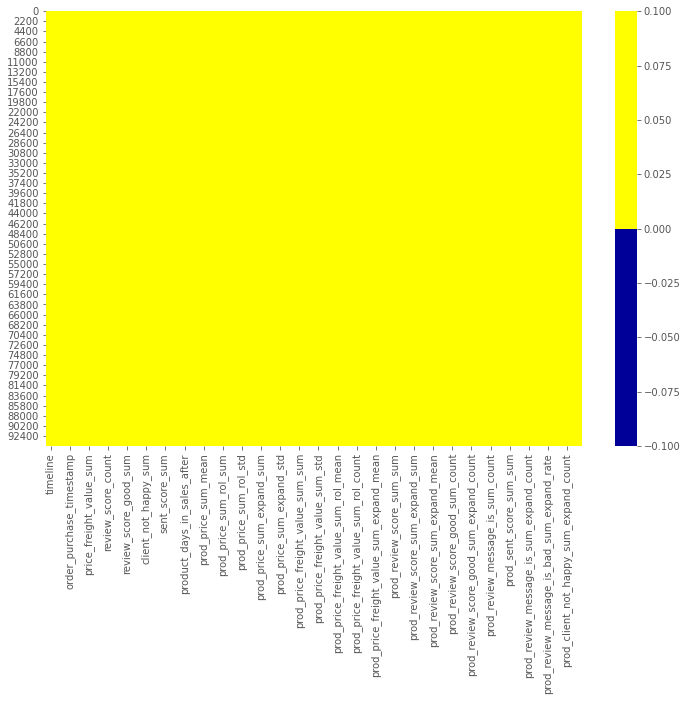

In [217]:
colours = ['#000099', '#ffff00'] # определяем цвета # желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(dfall.isnull(), cmap=sns.color_palette(colours))

#### 6.Присоединяем датафрейм с доп.фичами к основному и удаляем пропущенные значения

In [233]:
try:
    df_base["order_datetime"] = df_base["order_purchase_timestamp"].dt.date
    dfall["order_datetime"] = dfall["order_purchase_timestamp"].dt.date
except:
    df_base["order_datetime"] = pd.to_datetime(df_base["order_purchase_timestamp"]).dt.date
    dfall["order_datetime"] = pd.to_datetime(dfall["order_purchase_timestamp"]).dt.date

In [236]:
df_total=pd.merge(df_base, dfall.rename(columns={'product_id':'api_product_id','order_datetime':'api_order_datetime'}),
                 how='left', left_on=['product_id','order_datetime'], 
                  right_on=['api_product_id','api_order_datetime']).drop(['api_product_id','api_order_datetime'], axis=1)
print('df_base:',df_base.shape, df_total.shape)
df_total.head(1)

df_base: (112650, 66) (112650, 121)


,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp_x,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count,first_contact_date,landing_page_id,origin,order_datetime,timeline,order_purchase_timestamp_y,price_sum,price_freight_value_sum,review_score_sum,review_score_count,review_score_bad_sum,review_score_good_sum,review_message_is_sum,client_not_happy_sum,review_message_is_bad_sum,sent_score_sum,product_days_in_sales_before,product_days_in_sales_after,prod_price_sum_sum,prod_price_sum_mean,prod_price_sum_std,prod_price_sum_rol_sum,prod_price_sum_rol_mean,prod_price_sum_rol_std,prod_price_sum_rol_count,prod_price_sum_expand_sum,prod_price_sum_expand_mean,prod_price_sum_expand_std,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_rol_count,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_score_bad_sum_expand_rate,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.0,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870305,-44.593326,1.0,199.0,17.87,216.87,1.0,1.0,2018-01-23 00:00:00,2018-01-23 00:00:00,2018-01-23 16:06:31,2018-01-23 16:06:31,0c5b33dea94867d1ac402749e5438e8b,5.0,0.9,1.9,2.0,15.0,NaN,NaN,NaN,2018-01-14,2018-01-14,2018-01-14 00:00:00,199.0,216.87,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.9,76.0,0.0,597.0,199.0,0.0,199.0,14.214286,53.184987,14.0,597.0,0.801342,12.611044,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,14.0,652.82,0.876268,13.790346,13.0,4.333333,13.0,3.0,4.333333,0,3,0.0,3.0,0.0,3,0,2.6,0,3.0,0.0,0.0,2.6,0.0,0.0


In [250]:
columndrop=list(df_total.columns)
columndrop.remove('product_category_name')
df_total['product_category_name'].fillna('0', inplace=True)
df_total.fillna(0, inplace=True)



In [252]:
df_total.to_csv(os.path.join(PATH, 'df_total.csv'), sep=';', header=True, index=False)

In [565]:
a5=df_total.columns  # формируем список таблиц для выбора
#print(a5)
# Интерактивный выбор из списка и показ отфильтрованных строк (или другие действия, которые надо сделать)
@interact
def wwww(w5 = widgets.Dropdown(options=a5, value='review_message_is_sum',description='Таблица:')):
    #pass
    #global dfall
    description_table(df_total,w5)
    #df_filter_table=df_table_descr[df_table_descr['onesoil_table'].str.contains(w5)]
    #df_filter_column=df_column_descr[df_column_descr['onesoil_table'].str.contains(w5)]
    #display(HTML(df_filter_table.to_html(escape=False)))
    #display(HTML( df_filter_column.to_html(escape=False)))

interactive(children=(Dropdown(description='Таблица:', index=95, options=('order_id', 'order_item_id', 'produc…

In [573]:
df_total[df_total.columns[0:30]].isnull().mean()

order_id                         0.000000
order_item_id                    0.000000
product_id                       0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
seller_id                        0.000000
seller_zip_code_prefix           0.000000
seller_city                      0.000000
seller_state                     0.000000
sellers_geo_lat                  0.002246
sellers_geo_lng                  0.002246
mql_id                           0.955224
sdr_id                           0.955224
sr_id                            0.955224
won_date                         0.955224
business_segment                 0.955224
lead_type                        0.955650
lead_behaviour_profile           0.970679
has_company                      0.999734
has_gtin                         0.999734
average_stock                    0.999734
business_type                    0.955269
declared_product_catalog_size    1

In [575]:
list(df_total.columns)

['order_id',
 'order_item_id',
 'product_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'seller_id',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'sellers_geo_lat',
 'sellers_geo_lng',
 'mql_id',
 'sdr_id',
 'sr_id',
 'won_date',
 'business_segment',
 'lead_type',
 'lead_behaviour_profile',
 'has_company',
 'has_gtin',
 'average_stock',
 'business_type',
 'declared_product_catalog_size',
 'declared_monthly_revenue',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_id',
 'order_status',
 'order_purchase_timestamp_x',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customers_geo_lat',
 'customers_geo_lng',
 'order_item_count',
 'sum_price',
 'sum_fr

#### Делаем предварительные переменные со списком полей

In [12]:
col_id=['order_id', 'order_item_id', 'customer_id','customer_unique_id']

col_id2=['product_id','seller_id']
col_cat=['seller_city','seller_state','product_category_name','customer_city','customer_state']
col_itemorders_cat=['order_status']

col_itemorders_num=['price', 'freight_value','order_item_count', 'num_uniq_prod','price_freight_value']
col_review=['num_reviews_per_order','review_score', 'sent_score', 'sent_magnitude', 'sentences_count', 'token_count', 't_answer_first',  't_answer_last',
             't_answer_all','t_review_create_delivered',  't_review_create_estimated']
col_time=['t_approved',  't_logist_warehouse',  't_logist_fact',  't_logist_estimated',  't_logist_transport_days',  't_logist_transport_hours',
           't_delay',  't_delay_negative','status_delay',  'status_cancelled']  
col_timeline=['product_days_in_sales_before',  'product_days_in_sales_after', 'num_day_timeline']  
col_product_total=[ 'prod_price_freight_value_sum_sum',  'prod_price_freight_value_sum_mean', 'prod_price_freight_value_sum_std' ] 
col_product_roll=['prod_price_freight_value_sum_rol_sum','prod_price_freight_value_sum_rol_mean',  'prod_price_freight_value_sum_rol_std']
col_product_expand=['prod_price_freight_value_sum_expand_sum',  'prod_price_freight_value_sum_expand_mean', 'prod_price_freight_value_sum_expand_std']
col_review_total=[ 'prod_review_score_sum_sum',  'prod_review_score_sum_mean','prod_review_score_bad_sum_count',  'prod_review_score_good_sum_count',
                  'prod_review_message_is_sum_count',  'prod_review_message_is_bad_sum_count','prod_sent_score_sum_sum',  'prod_client_not_happy_sum_count'] 
col_review_expand= ['prod_review_score_sum_expand_sum',  'prod_review_score_count_expand_count', 'prod_review_score_sum_expand_mean',
                    'prod_review_score_bad_sum_expand_count',  'prod_review_score_good_sum_expand_count',
                    'prod_review_message_is_sum_expand_count',  'prod_review_message_is_bad_sum_expand_count', 'prod_review_message_is_bad_sum_expand_rate',
                    'prod_sent_score_sum_expand_sum', 'prod_client_not_happy_sum_expand_count', 'prod_review_score_bad_sum_expand_rate2']
col_label=['client_not_happy','review_score_bad','review_score_good','review_message_is',  'review_message_is_bad']

col_all=col_id2+col_cat+col_itemorders_num+col_itemorders_cat+col_review+col_time+col_timeline+col_product_total+col_product_roll+col_product_expand\
+col_review_total+col_review_expand+col_label

col_all_num=col_itemorders_num+col_review+col_time+col_timeline+col_product_total+col_product_roll+col_product_expand\
+col_review_total+col_review_expand+col_label

col_all_cat=col_id2+col_cat+col_itemorders_cat

col_all_num_now=col_itemorders_num+col_review+col_time+col_product_roll+col_product_expand+col_review_expand+col_label

col_all_classbin=col_all_cat+col_itemorders_num+col_time+col_review_expand

# Задачи машинного обучения
- прогнозирование среднедневных продаж продукта текущего заказа;
- задача бинарной классификации - спрогнозировать отнесение клиента к категории недовольных.


## Блок подготовки датасета к машинному обучению

- либо копируем датасет с предыдущих этапов, либо загружаем сохраненный CSV
- добавляем дополнительные фичи, которые потребуются

In [597]:
# делаем копию датафрейма с заполнением пропущенных значений нулями
df=df_total[col_all].fillna(0)

In [33]:
del df1

In [604]:
# делаем глубокую копию 
df1 = df.copy(deep=True)

In [688]:
# сохраняем CSV
df1.to_csv(os.path.join(PATH, 'df1_all.csv'), sep=';', header=True, index=False)

In [34]:
# читаем CSV
df1 = pd.read_csv(os.path.join(PATH, 'df1_all.csv'), sep=';')

In [10]:
print(df1.shape)
df1.head(1)

(112650, 70)


,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,order_status,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad
0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,borda da mata,MG,moveis_decoracao,para de minas,MG,199.0,17.87,1.0,1.0,216.87,delivered,1.0,5.0,0.9,1.9,2.0,15.0,16.1,16.1,16.1,0.0,-13.0,0.233333,1.0,7.0,21,6.0,144.7,13.0,1.0,0,0,76.0,0.0,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,652.82,0.876268,13.790346,13.0,4.333333,0,3,3,0,2.6,0,13.0,3.0,4.333333,0.0,3.0,3.0,0.0,0.0,2.6,0.0,0.0,0,0,1,1,0


In [35]:
df1['product_category_name'].fillna('0',inplace=True)

In [17]:
df1[df1.columns[1:3]].isnull().mean()

seller_id      0.0
seller_city    0.0
dtype: float64

In [622]:
# создаем пустой датафрейм с колонками для категориального кодирования
# df101=pd.DataFrame(columns=col_all_cat)

In [37]:
# проводим кодирование выбранных категориальных колонок
encoder = OrdinalEncoder()
df5555 = encoder.fit_transform(df1[col_all_cat]) #.drop(col_all_num, axis=1))

In [38]:
# создаем датафрейм с колонками для категориального кодирования
df101=pd.DataFrame(df5555, columns=col_all_cat)

In [39]:
df101.shape

(112650, 8)

In [40]:
df101.head()

,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
0,25667.0,1117.0,77.0,8.0,55.0,2658.0,10.0,2.0
1,15322.0,1919.0,196.0,22.0,63.0,329.0,25.0,2.0
2,18181.0,1371.0,517.0,22.0,71.0,1515.0,25.0,2.0
3,6384.0,1996.0,517.0,22.0,12.0,3407.0,25.0,2.0
4,27627.0,2481.0,483.0,22.0,12.0,2860.0,25.0,2.0


In [41]:
# объединяем числовые и закодированные категориальные колонки
df102=df1[col_all_num].join(df101, how='inner')#, lsuffix='_first', rsuffix='_third')
del df101
print(df102.shape)
df102.head(2)

(112650, 70)


,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
0,199.00,17.87,1.0,1.0,216.87,1.0,5.0,0.9,1.9,2.0,15.0,16.10,16.10,16.10,0.0,-13.0,0.233333,1.0,7.0,21,6.0,144.700000,13.0,1.0,0,0,76.0,0.0,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,652.82,0.876268,13.790346,13.0,4.333333,0,3,3,0,2.6,0,13.0,3.0,4.333333,0.0,3.0,3.0,0.0,0.0,2.6,0.0,0.0,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,2658.0,10.0,2.0
1,12.99,12.79,1.0,1.0,25.78,1.0,4.0,0.0,0.0,0.0,0.0,16.65,16.65,16.65,0.0,-5.0,0.150000,2.0,6.0,11,4.0,96.066667,5.0,1.0,0,0,0.0,9.0,951.0,51.56,25.780000,0.000000,25.78,1.841429,6.889995,25.78,0.027108,0.835974,8.0,4.000000,0,2,1,0,0.9,0,4.0,1.0,4.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,15322.0,1919.0,196.0,22.0,63.0,329.0,25.0,2.0


In [47]:
df102[df102['product_id']==25667].head(7)

,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
0,199.0,17.87,1.0,1.0,216.87,1.0,5.0,0.9,1.9,2.0,15.0,16.100000,16.100000,16.100000,0.0,-13.0,0.233333,1.0,7.0,21,6.0,144.700000,13.0,1.0,0,0,76.0,0.0,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,652.82,0.876268,13.790346,13.0,4.333333,0,3,3,0,2.6,0,13.0,3.0,4.333333,0.0,3.0,3.0,0.0,0.0,2.6,0.0,0.0,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,2658.0,10.0,2.0
18782,199.0,20.08,2.0,2.0,219.08,1.0,4.0,0.8,0.8,1.0,28.0,23.916667,23.916667,23.916667,0.0,-15.0,1.933333,1.0,9.0,24,7.0,188.966667,15.0,1.0,0,0,0.0,76.0,669.0,652.82,217.606667,1.275944,219.08,15.648571,58.551593,219.08,0.327474,8.470122,13.0,4.333333,0,3,3,0,2.6,0,4.0,1.0,4.000000,0.0,1.0,1.0,0.0,0.0,0.8,0.0,0.0,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,557.0,6.0,2.0
33270,199.0,17.87,1.0,1.0,216.87,1.0,4.0,0.9,0.9,1.0,14.0,66.200000,66.200000,66.200000,0.0,-20.0,23.833333,3.0,5.0,25,1.0,39.433333,20.0,1.0,0,0,68.0,8.0,737.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,435.95,0.591520,11.347451,13.0,4.333333,0,3,3,0,2.6,0,8.0,2.0,4.000000,0.0,2.0,2.0,0.0,0.0,1.7,0.0,0.0,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,1128.0,10.0,2.0


In [ ]:
product_days_in_sales_before, product_days_in_sales_after, prod_price_freight_value_sum_sum, prod_price_freight_value_sum_expand_sum

## Функции тренировки и оценки моделей

In [113]:
def check_log_model_regr(df, feats, column_label, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df[column_label].isnull() ].copy()

    X = df_train[feats]
    y = df_train[column_label]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

In [191]:
def check_log_model_class(df, feats, column_label, model, cv=4, scoring=confusion_matrix, show_eli5=True):
    df_train = df[ ~df[column_label].isnull() ].copy()

    X = df_train[feats]
    y = df_train[column_label]
    
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    accuracys=[]
    nda=np.array([[0, 0], [0, 0]])
  

    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        score = scoring(y_test, y_pred, labels=model.classes_)
        nda=nda+np.array(score)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracys.append(accuracy)

      
        
    result= np.mean(accuracys), nda
    
    
    sns.heatmap(nda, annot=True, fmt='d', cmap='Blues')
    if show_eli5:
        model.fit(X, y)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

## Задача регрессии

**"Оценить вероятность возврата клиента"**
- Так как в базе очень мало записей с повторными заказами по одному клиенту, то преобразуем задачу в **Оценить вероятность выбора конкретного продукта новым или повторным клиентом**.
- в данном случае показатель среднего чека не использую, так как в заказах преобладают заказы с одной позицией и нет потенциала увеличивать именно стоимость заказа в среднем. Но есть потенциал увеличения количества заказов за определенный промежуток времени, который напрямую влияет на среднедневные продажи.
- Гипотеза: товары, которые по совокупности наблюдаемых клиентом характеристик, в его глазах более предпочтительны, должны лучше продаваться и следовательно продажи после данного заказа должны быть лучше, чем до заказа. И наоборот.
- Для ее оценки будем использовать **"Среднедневная сумма продаж в период от даты совершения заказа до последней даты продажи этого товара** 

- в качестве ФИЧ буду использовать только те, которые на момент заказа доступны клиенту и напрямую влияют на его выбор, а также параметры продукты и некоторые показатели, которые известны поставщику (например среднедневная сумма продаж на момент нового заказа)

- из датасета удаляю продукты, которые ИЛИ 1)продались только один раз за все время (по ним нет никакой статистически значимой истории); 2) первая продажа товара (так как среднедневные продажи до ее совершения невозможно рассчитать); 3) последняя продажа товара (так как среднедневные продажи после нее невозможно рассчитать). (Конечно, датасет сократился почти в 2 раза, но строки без прогнозного значения создали бы лишний шум для модели регрессии. При необходимости, можно сделать кластерный анализ, чтобы понять, чем например продукты, проданные только один раз, отличаются от других продуктов).

In [69]:
df102.head(5)

,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
0,199.00,17.87,1.0,1.0,216.87,1.0,5.0,0.9,1.9,2.0,15.0,16.100000,16.100000,16.100000,0.0,-13.0,0.233333,1.0,7.0,21,6.0,144.700000,13.0,1.0,0,0,76.0,0.0,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,652.82,0.876268,13.790346,13.0,4.333333,0,3,3,0,2.6,0,13.0,3.0,4.333333,0.0,3.0,3.0,0.0,0.0,2.6,0.0,0.000000,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,2658.0,10.0,2.0
1,12.99,12.79,1.0,1.0,25.78,1.0,4.0,0.0,0.0,0.0,0.0,16.650000,16.650000,16.650000,0.0,-5.0,0.150000,2.0,6.0,11,4.0,96.066667,5.0,1.0,0,0,0.0,9.0,951.0,51.56,25.780000,0.000000,25.78,1.841429,6.889995,25.78,0.027108,0.835974,8.0,4.000000,0,2,1,0,0.9,0,4.0,1.0,4.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0,15322.0,1919.0,196.0,22.0,63.0,329.0,25.0,2.0
2,19.90,11.85,1.0,1.0,31.75,1.0,4.0,0.0,0.0,0.0,0.0,242.666667,242.666667,242.666667,0.0,-16.0,0.266667,1.0,8.0,24,6.0,164.916667,16.0,1.0,0,0,14.0,52.0,710.0,99.44,33.146667,3.091445,31.75,2.267857,8.485544,62.75,0.088380,1.664157,13.0,4.333333,0,3,1,0,0.0,0,9.0,2.0,4.500000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0,18181.0,1371.0,517.0,22.0,71.0,1515.0,25.0,2.0
3,145.95,11.65,1.0,1.0,157.60,1.0,1.0,-0.2,0.5,2.0,32.0,72.866667,72.866667,72.866667,0.0,1.0,23.900000,8.0,9.0,9,1.0,41.650000,-1.0,-1.0,1,0,128.0,0.0,809.0,320.82,160.410000,3.973940,157.60,11.257143,42.120372,320.82,0.396564,7.972051,6.0,3.000000,1,1,1,1,-0.2,1,6.0,2.0,3.000000,1.0,1.0,1.0,1.0,1.0,-0.2,1.0,1.000000,1,1,0,1,1,6384.0,1996.0,517.0,22.0,12.0,3407.0,25.0,2.0
4,59.99,8.88,1.0,1.0,68.87,1.0,5.0,0.4,0.4,1.0,16.0,4.066667,4.066667,4.066667,0.0,-10.0,0.183333,2.0,4.0,15,1.0,42.616667,10.0,1.0,0,0,251.0,97.0,814.0,3988.09,83.085208,34.020253,506.58,36.184286,37.669654,2146.72,2.637248,15.276872,231.0,4.812500,6,44,23,8,5.3,10,119.0,30.0,3.966667,5.0,22.0,10.0,4.0,0.4,1.4,5.0,0.227273,0,0,1,1,0,27627.0,2481.0,483.0,22.0,12.0,2860.0,25.0,2.0


In [66]:
#df102.drop(['filter_countitems'], axis=1, inplace=True)

In [78]:
f1= df102['product_days_in_sales_before']!=0
f2= df102['product_days_in_sales_after']!=0
df_to_model=df102[(f1) & (f2)].copy()
print(df_to_model.shape)
df_to_model.head(2)

(60612, 70)


,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
2,19.90,11.85,1.0,1.0,31.75,1.0,4.0,0.0,0.0,0.0,0.0,242.666667,242.666667,242.666667,0.0,-16.0,0.266667,1.0,8.0,24,6.0,164.916667,16.0,1.0,0,0,14.0,52.0,710.0,99.44,33.146667,3.091445,31.75,2.267857,8.485544,62.75,0.088380,1.664157,13.0,4.333333,0,3,1,0,0.0,0,9.0,2.0,4.500000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0,18181.0,1371.0,517.0,22.0,71.0,1515.0,25.0,2.0
4,59.99,8.88,1.0,1.0,68.87,1.0,5.0,0.4,0.4,1.0,16.0,4.066667,4.066667,4.066667,0.0,-10.0,0.183333,2.0,4.0,15,1.0,42.616667,10.0,1.0,0,0,251.0,97.0,814.0,3988.09,83.085208,34.020253,506.58,36.184286,37.669654,2146.72,2.637248,15.276872,231.0,4.812500,6,44,23,8,5.3,10,119.0,30.0,3.966667,5.0,22.0,10.0,4.0,0.4,1.4,5.0,0.227273,0,0,1,1,0,27627.0,2481.0,483.0,22.0,12.0,2860.0,25.0,2.0


In [79]:
df_to_model['mean_sales_per_day_before']=df_to_model['prod_price_freight_value_sum_expand_sum']/df_to_model['product_days_in_sales_before']
df_to_model['mean_sales_per_day_after']=(df_to_model['prod_price_freight_value_sum_sum']-\
                                         df_to_model['prod_price_freight_value_sum_expand_sum'])/df_to_model['product_days_in_sales_after']
df_to_model.head(2)

,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status,mean_sales_per_day_before,mean_sales_per_day_after
2,19.90,11.85,1.0,1.0,31.75,1.0,4.0,0.0,0.0,0.0,0.0,242.666667,242.666667,242.666667,0.0,-16.0,0.266667,1.0,8.0,24,6.0,164.916667,16.0,1.0,0,0,14.0,52.0,710.0,99.44,33.146667,3.091445,31.75,2.267857,8.485544,62.75,0.088380,1.664157,13.0,4.333333,0,3,1,0,0.0,0,9.0,2.0,4.500000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0,18181.0,1371.0,517.0,22.0,71.0,1515.0,25.0,2.0,4.482143,0.705577
4,59.99,8.88,1.0,1.0,68.87,1.0,5.0,0.4,0.4,1.0,16.0,4.066667,4.066667,4.066667,0.0,-10.0,0.183333,2.0,4.0,15,1.0,42.616667,10.0,1.0,0,0,251.0,97.0,814.0,3988.09,83.085208,34.020253,506.58,36.184286,37.669654,2146.72,2.637248,15.276872,231.0,4.812500,6,44,23,8,5.3,10,119.0,30.0,3.966667,5.0,22.0,10.0,4.0,0.4,1.4,5.0,0.227273,0,0,1,1,0,27627.0,2481.0,483.0,22.0,12.0,2860.0,25.0,2.0,8.552669,18.983196


### Простая базовая модель

Средняя ошибка - 26 единиц.

In [44]:
from sklearn.dummy import DummyRegressor

In [80]:
feats = ["product_id"]
X = df_to_model[feats]
y = df_to_model["mean_sales_per_day_after"]

model = DummyRegressor(strategy="mean")
model.fit(X, y)
y_pred = model.predict(X)

print('Dummy-mean: ',mean_absolute_error(y, y_pred))

model = DummyRegressor(strategy="median")
model.fit(X, y)
y_pred = model.predict(X)

print('Dummy-median:' ,mean_absolute_error(y, y_pred))


Dummy-mean:  32.872698429853536
Dummy-median: 26.669633768228348


In [88]:
feats = df_to_model.columns
feats

Index(['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       'price_freight_value', 'num_reviews_per_order', 'review_score',
       'sent_score', 'sent_magnitude', 'sentences_count', 'token_count',
       't_answer_first', 't_answer_last', 't_answer_all',
       't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_logist_transport_hours', 't_delay',
       't_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before', 'product_days_in_sales_after',
       'num_day_timeline', 'prod_price_freight_value_sum_sum',
       'prod_price_freight_value_sum_mean', 'prod_price_freight_value_sum_std',
       'prod_price_freight_value_sum_rol_sum',
       'prod_price_freight_value_sum_rol_mean',
       'prod_price_freight_value_sum_rol_std',
       'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_exp

### Вариант 1. Вообще все поля (даже те, которые мы уже знаем наверняка)

В этом варианте конечно ошибка невелика, так как мы по факту знаем полные исторические данные. Поэтому ее можно считать идеальной моделью

In [86]:
feats = list(df_to_model.columns) # копируем весь перечень колонок
col_label='mean_sales_per_day_after' # определяем целевую величину 
feats.remove(col_label) # удаляем целевыую величину из списка фич
check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:17,  4.47s/it]


(4.7020739786457, 0.1811931930235857)


Weight,Feature
0.2765,prod_price_freight_value_sum_rol_sum
0.2621,prod_price_freight_value_sum_sum
0.1011,product_days_in_sales_after
0.0541,prod_price_freight_value_sum_std
0.0412,prod_price_freight_value_sum_mean
0.0289,prod_price_freight_value_sum_expand_mean
0.0175,prod_review_message_is_sum_count
0.0144,prod_price_freight_value_sum_rol_std
0.0139,order_item_count
0.0137,prod_review_score_sum_sum


### Вариант2. Только фичи, которые указал в задании, с учетом известной поставщику статистики продаж своего товара

Здесь ошибка чуть выше, так как мы на момент прогнозирования знаем только результаты на дату заказа

In [89]:
feats=['price', 'freight_value',    'status_cancelled',
        'prod_price_freight_value_sum_rol_sum',
       'prod_price_freight_value_sum_rol_mean',
       'prod_price_freight_value_sum_rol_std',
       'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
      'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state','mean_sales_per_day_before']

col_label='mean_sales_per_day_after' # определяем целевую величину сумма продаж в целом за весь период

check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:08,  2.19s/it]


(12.772728182852415, 0.4107866314672566)


Weight,Feature
0.6663,prod_price_freight_value_sum_rol_sum
0.0700,prod_price_freight_value_sum_expand_sum
0.0203,price
0.0193,mean_sales_per_day_before
0.0185,prod_price_freight_value_sum_expand_std
0.0179,seller_state
0.0176,prod_price_freight_value_sum_rol_std
0.0174,seller_city
0.0156,product_id
0.0150,prod_price_freight_value_sum_expand_mean


### Вариант 3. Оставляем только фичи, доступные клиенту для анализа, чтобы спрогнозировать его поведение

А это в основном информация о товаре, о поставщике и об наблюдаемых им оценках и отзывов по этому товару. И убираем из списка фич с очень высокой корреляцией друг с другом.



In [91]:
# расширенный набор фич, с учетом возможной взаимной высокой корреляцией
feats=['price', 'freight_value',    
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_sent_score_sum_expand_sum',  # оценку тональности оставляю, так по идее клиент сам делает такую оценку, читая отзывы
        'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state']


col_label='mean_sales_per_day_after' # определяем целевую величину сумма продаж в целом за весь период

check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:04,  1.17s/it]


(14.062371959734003, 0.4685613469676275)


Weight,Feature
0.4441,prod_review_score_count_expand_count
0.2251,price
0.0669,prod_review_score_bad_sum_expand_count
0.0379,prod_review_score_good_sum_expand_count
0.0338,seller_state
0.0312,product_category_name
0.0308,seller_id
0.0292,seller_city
0.0252,product_id
0.0215,prod_review_message_is_sum_expand_count


In [106]:
# подвариант с минимальным набором фич - Итоговый набор фич
feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
        'product_id', 'seller_id', 'product_category_name', 'customer_city']


col_label='mean_sales_per_day_after' # определяем целевую величину сумма продаж в целом за весь период

check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:04,  1.13s/it]


(14.524259562744303, 0.35675329039488757)


Weight,Feature
0.3869,prod_review_score_good_sum_expand_count
0.3369,price
0.1095,prod_review_score_bad_sum_expand_count
0.0549,seller_id
0.0497,product_category_name
0.0394,product_id
0.0162,freight_value
0.0065,customer_city


---------------------------------------  ---------------------------------------  ---------
prod_review_score_good_sum_expand_count  prod_review_score_bad_sum_expand_count   0.921702
mean_sales_per_day_after                 price                                    0.403043
freight_value                            price                                    0.377435
mean_sales_per_day_after                 prod_review_score_good_sum_expand_count  0.18983
mean_sales_per_day_after                 prod_review_score_bad_sum_expand_count   0.174603
mean_sales_per_day_after                 freight_value                            0.135205
seller_id                                prod_review_score_bad_sum_expand_count   0.123149
customer_city                            freight_value                            0.0864489
seller_id                                prod_review_score_good_sum_expand_count  0.0829332
prod_review_score_bad_sum_expand_count   price                                    0.0667

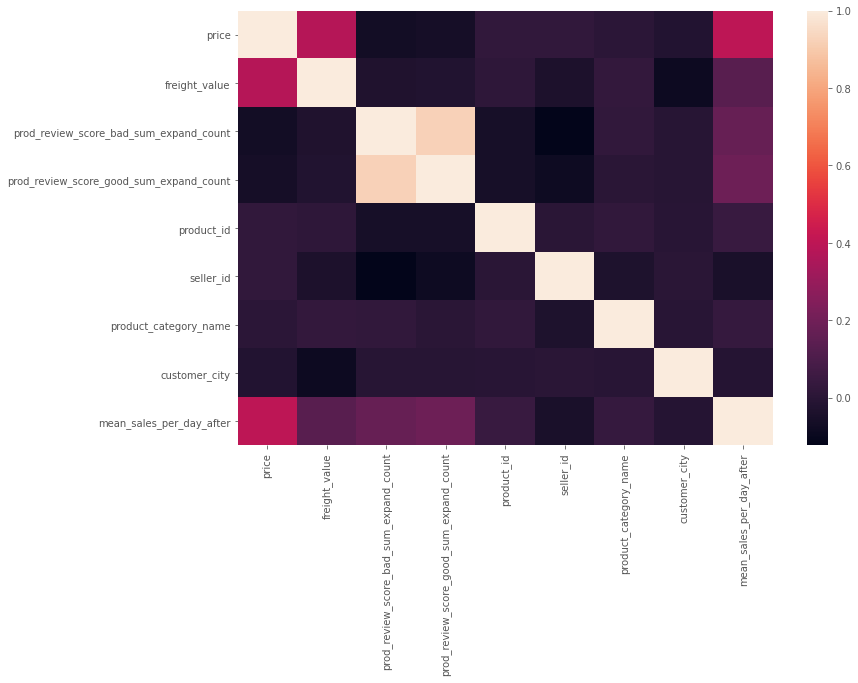

In [105]:

feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
        'product_id', 'seller_id', 'product_category_name', 'customer_city',
      'mean_sales_per_day_after']

corr_matrix = df_to_model[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

---------------------------------------  ---------------------------------------  ---------
prod_review_message_is_sum_expand_count  prod_review_score_good_sum_expand_count  0.975689
prod_review_message_is_sum_expand_count  prod_review_score_bad_sum_expand_count   0.95837
prod_sent_score_sum_expand_sum           prod_review_score_good_sum_expand_count  0.957315
prod_sent_score_sum_expand_sum           prod_review_message_is_sum_expand_count  0.948638
prod_review_score_good_sum_expand_count  prod_review_score_bad_sum_expand_count   0.921702
prod_sent_score_sum_expand_sum           prod_review_score_bad_sum_expand_count   0.851812
mean_sales_per_day_after                 price                                    0.403043
freight_value                            price                                    0.377435
mean_sales_per_day_after                 prod_review_score_good_sum_expand_count  0.18983
mean_sales_per_day_after                 prod_review_message_is_sum_expand_count  0.180634


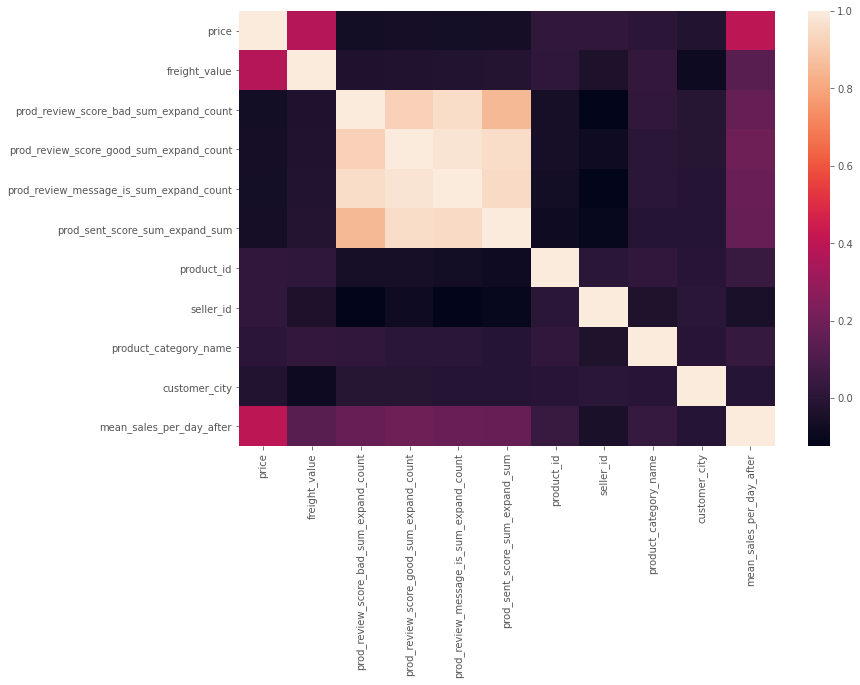

In [103]:
# пример высокой корреляции наличия текстового отзыва с оценками
feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_sent_score_sum_expand_sum',  # оценку тональности оставляю, так по идее клиент сам делает такую оценку, читая отзывы
        'product_id', 'seller_id', 'product_category_name', 'customer_city',
      'mean_sales_per_day_after']

corr_matrix = df_to_model[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

#### Вариант 3.1. Подбираем лучшие гиперпараметры модели

In [108]:
feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
        'product_id', 'seller_id', 'product_category_name', 'customer_city']


col_label='mean_sales_per_day_after' # определяем целевую величину сумма продаж в целом за весь период

for itemdepth in [5,7,9,11]:
    for itemestim in [50,100, 200,500,1000,1500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)
        


4it [00:03,  1.21it/s]


(14.524259562744303, 0.35675329039488757)
5 -- 50 -- <IPython.core.display.HTML object>


4it [00:06,  1.69s/it]


(12.783027952396898, 0.2779542838990077)
5 -- 100 -- <IPython.core.display.HTML object>


4it [00:12,  3.02s/it]


(11.164837319851685, 0.34802979627820774)
5 -- 200 -- <IPython.core.display.HTML object>


4it [00:29,  7.50s/it]


(9.291599544291833, 0.3269584628047773)
5 -- 500 -- <IPython.core.display.HTML object>


4it [01:01, 15.50s/it]


(8.292078774514298, 0.32001846495307557)
5 -- 1000 -- <IPython.core.display.HTML object>


4it [01:33, 23.43s/it]


(7.912971129161752, 0.29889404106730405)
5 -- 1500 -- <IPython.core.display.HTML object>


4it [00:04,  1.15s/it]


(11.646680312448224, 0.417251364921621)
7 -- 50 -- <IPython.core.display.HTML object>


4it [00:08,  2.24s/it]


(10.25534024337383, 0.38105477607390137)
7 -- 100 -- <IPython.core.display.HTML object>


4it [00:18,  4.53s/it]


(8.940031055598972, 0.3657103447913572)
7 -- 200 -- <IPython.core.display.HTML object>


4it [00:44, 11.24s/it]


(7.795751672918704, 0.36732299320903766)
7 -- 500 -- <IPython.core.display.HTML object>


4it [01:28, 22.03s/it]


(7.282967135270357, 0.33923381716902357)
7 -- 1000 -- <IPython.core.display.HTML object>


4it [02:13, 33.43s/it]


(7.079981955452805, 0.3388709315572956)
7 -- 1500 -- <IPython.core.display.HTML object>


4it [00:06,  1.56s/it]


(9.62386146214453, 0.4502112963768168)
9 -- 50 -- <IPython.core.display.HTML object>


4it [00:12,  3.15s/it]


(8.508433255900421, 0.3500235789988499)
9 -- 100 -- <IPython.core.display.HTML object>


4it [00:24,  6.15s/it]


(7.747776793329228, 0.2742978782649581)
9 -- 200 -- <IPython.core.display.HTML object>


4it [00:59, 14.89s/it]


(7.1554071754905015, 0.2597328632904766)
9 -- 500 -- <IPython.core.display.HTML object>


4it [01:58, 29.61s/it]


(6.961135268092303, 0.25167176742888225)
9 -- 1000 -- <IPython.core.display.HTML object>


4it [03:03, 45.89s/it]


(6.90503532384281, 0.2507118942846689)
9 -- 1500 -- <IPython.core.display.HTML object>


4it [00:07,  1.99s/it]


(8.317186917416858, 0.3055281973845475)
11 -- 50 -- <IPython.core.display.HTML object>


4it [00:16,  4.00s/it]


(7.5802010061077025, 0.3530543042123798)
11 -- 100 -- <IPython.core.display.HTML object>


4it [00:30,  7.54s/it]


(7.104312648200089, 0.3534025528224503)
11 -- 200 -- <IPython.core.display.HTML object>


4it [01:15, 18.92s/it]


(6.8170358896071, 0.34776008902710026)
11 -- 500 -- <IPython.core.display.HTML object>


4it [02:19, 34.77s/it]


(6.759234345454075, 0.3484177842228564)
11 -- 1000 -- <IPython.core.display.HTML object>


4it [02:39, 39.98s/it]


(6.759234343591553, 0.34841778229393583)
11 -- 1500 -- <IPython.core.display.HTML object>


#### Вариант 3. Финальная модель после подбора гиперпараметров.

**ВЫВОДЫ (на основе того набора показателей, которые рассчитали):**
- Цена продукта и количество хороших оценок (4,5) по нему оказывают основное влияние на прогнозируемые среднедневные продажи.
- Другие важные факторы: количество плохих оценок (1,2) и стоимость доставки
- при очень ограниченном количестве фич модель не намного хуже, чем моделирование на полных исторических данных

In [109]:
# подвариант с минимальным набором фич - Итоговый набор фич
feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
        'product_id', 'seller_id', 'product_category_name', 'customer_city']


col_label='mean_sales_per_day_after' # определяем целевую величину сумма продаж в целом за весь период

check_log_model_regr(df_to_model, feats, col_label, xgb.XGBRegressor(max_depth=11, n_estimators=500, learning_rate=0.3, random_state=0))

4it [01:14, 18.67s/it]


(6.8170358896071, 0.34776008902710026)


Weight,Feature
0.2267,prod_review_score_good_sum_expand_count
0.2208,price
0.1594,product_category_name
0.1455,seller_id
0.1135,product_id
0.0938,prod_review_score_bad_sum_expand_count
0.0239,freight_value
0.0163,customer_city


---------------------------------------  ---------------------------------------  ---------
prod_review_score_good_sum_expand_count  prod_review_score_bad_sum_expand_count   0.921702
mean_sales_per_day_after                 price                                    0.403043
freight_value                            price                                    0.377435
mean_sales_per_day_after                 prod_review_score_good_sum_expand_count  0.18983
mean_sales_per_day_after                 prod_review_score_bad_sum_expand_count   0.174603
mean_sales_per_day_after                 freight_value                            0.135205
seller_id                                prod_review_score_bad_sum_expand_count   0.123149
customer_city                            freight_value                            0.0864489
seller_id                                prod_review_score_good_sum_expand_count  0.0829332
prod_review_score_bad_sum_expand_count   price                                    0.0667

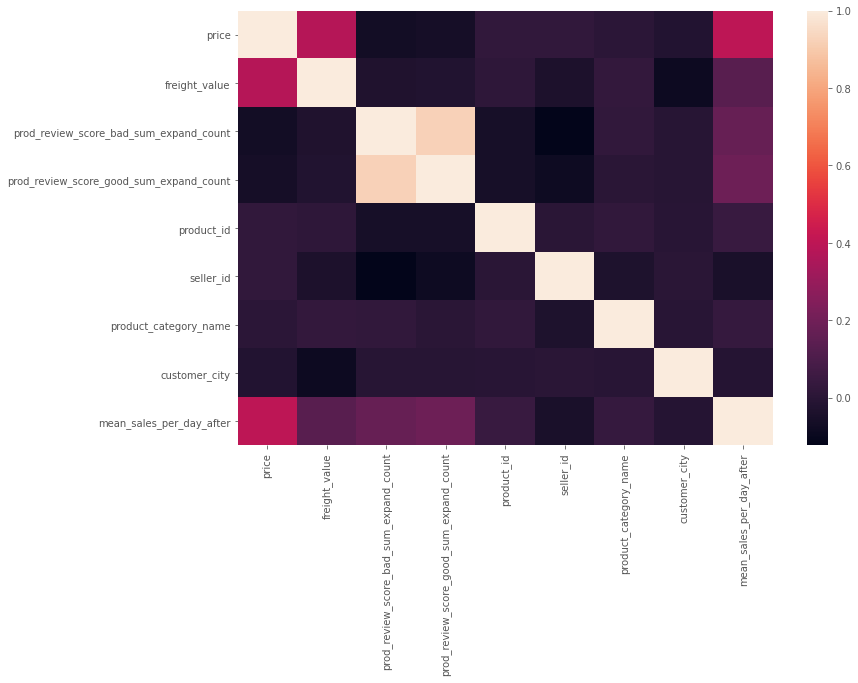

In [110]:
feats=['price', 'freight_value',    
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
        'product_id', 'seller_id', 'product_category_name', 'customer_city',
      'mean_sales_per_day_after']

corr_matrix = df_to_model[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

## Задача классификации

**"Спрогнозировать удовлетворенность клиента"**
- В данном случае Неудовлетворенным клиентом будем считать того, кто либо поставил плохую оценку (1,2), либо написал текстовой отзыв с отрицательной тональностью, либо и то, и другое. Так как ряд заказов содержал несколько оценок, то брались данные по последнему отзыву, как финальная удовлетворенность клиента.

- Гипотеза: если какие-то параметры взаимодействия клиента с маркетплейсом в процессе заказа товара и его фактического получения, а также его потребительский опыт в отношении полученного продукта существенно отклонились от ожиданий, то с высокой вероятностью клиент на это отгреагирует плохими оценками и комментариями.

- датасет будем использовать весь, без урезания, как в задаче регрессии, так как мы прогнозируем результат каждой сделки

In [111]:
print(df102.shape)
df102.head(2)

(112650, 70)


,price,freight_value,order_item_count,num_uniq_prod,price_freight_value,num_reviews_per_order,review_score,sent_score,sent_magnitude,sentences_count,token_count,t_answer_first,t_answer_last,t_answer_all,t_review_create_delivered,t_review_create_estimated,t_approved,t_logist_warehouse,t_logist_fact,t_logist_estimated,t_logist_transport_days,t_logist_transport_hours,t_delay,t_delay_negative,status_delay,status_cancelled,product_days_in_sales_before,product_days_in_sales_after,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2,client_not_happy,review_score_bad,review_score_good,review_message_is,review_message_is_bad,product_id,seller_id,seller_city,seller_state,product_category_name,customer_city,customer_state,order_status
0,199.00,17.87,1.0,1.0,216.87,1.0,5.0,0.9,1.9,2.0,15.0,16.10,16.10,16.10,0.0,-13.0,0.233333,1.0,7.0,21,6.0,144.700000,13.0,1.0,0,0,76.0,0.0,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,652.82,0.876268,13.790346,13.0,4.333333,0,3,3,0,2.6,0,13.0,3.0,4.333333,0.0,3.0,3.0,0.0,0.0,2.6,0.0,0.0,0,0,1,1,0,25667.0,1117.0,77.0,8.0,55.0,2658.0,10.0,2.0
1,12.99,12.79,1.0,1.0,25.78,1.0,4.0,0.0,0.0,0.0,0.0,16.65,16.65,16.65,0.0,-5.0,0.150000,2.0,6.0,11,4.0,96.066667,5.0,1.0,0,0,0.0,9.0,951.0,51.56,25.780000,0.000000,25.78,1.841429,6.889995,25.78,0.027108,0.835974,8.0,4.000000,0,2,1,0,0.9,0,4.0,1.0,4.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,15322.0,1919.0,196.0,22.0,63.0,329.0,25.0,2.0


In [146]:
df102.groupby('client_not_happy').agg({'client_not_happy':'count'})

,client_not_happy
client_not_happy,
0,91534
1,21116


### Вариант 1. Набор фич включает логистику, товар, поставщика и оценки товара на маркетплейсе

Для данной задачи мы имеем 4 квадранта по степени убывания важности для предпринятия действий маркетплейсом
1. (8869) - фактически недовольный клиент, но модель их НЕ предсказала. И это (8869/21116=42%) 42% недовольных клиентов, которые маркетплейс пропустит мимо, и они оставят негативные отметки на сайте, ухудшая продажи. Т.е. это самая важная категория клиентов, с которой надо предпринимать оперативные действия ДО момент оставления ими отзыва.
2. (12247) - фактически недовольные клиенты и модель их предсказала. Это тоже группа с которой надо работать маркетплейсу, но так как модель их предсказала правильно, то нет аврала.
3. (1612) - фактически довольные клиенты, но модель посчитала их недовольными. Есть конечно риск, что при звонке от маркетплейса в уверенности что это недовольный клиент, можно ухудшить удовлетворенность. Но если сценарий беседы с клиентом выстраивать правильно, то все закончится еще на первой стадии разговора и прояснении ситуации.
4. (89922) - фактически довольные клиенты, и модель их правильно предсказала. Здесь маркетплейсу не требуется предпринимать активных действий.

В итоге нам в данной задаче необходимости выбрать модель, которая выдает наименьшее количество клиентов в 1 группе и наибольшее во 2ой

Вариант не очень - только 58% неудовлетворенных клиентов смогла выявить.

4it [00:09,  2.33s/it]


0.9069596252983664


Weight,Feature
0.4076,prod_review_score_bad_sum_expand_count
0.3260,prod_review_score_good_sum_expand_count
0.0901,t_delay
0.0651,status_cancelled
0.0388,t_logist_fact
0.0181,t_answer_first
0.0096,t_logist_estimated
0.0082,price_freight_value
0.0082,product_category_name
0.0081,customer_city


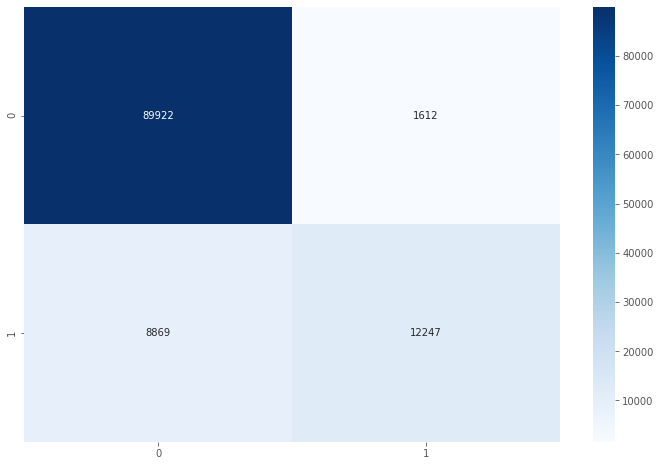

In [181]:
feats=['price_freight_value', 't_answer_first', 
       't_logist_fact', 't_logist_estimated', 't_delay', 't_delay_negative', 'status_delay', 'status_cancelled', # это показатели логистики, опоздания и отмены заказа
       'prod_review_score_bad_sum_expand_count', 'prod_review_score_good_sum_expand_count', # показатели оценок на момент заказа - это формирование ожиданий клиента
       'product_id', 'seller_id', 'product_category_name', 'customer_city','order_status']

col_label='client_not_happy' # определяем удовлетворен или нет клиент в итоге
check_log_model_class(df102, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

---------------------------------------  --------------------------------------  --------
prod_review_score_good_sum_expand_count  prod_review_score_bad_sum_expand_count  0.922624
order_status                             status_cancelled                        0.720379
t_delay_negative                         t_logist_fact                           0.707188
t_delay_negative                         t_delay                                 0.651963
status_delay                             t_delay_negative                        0.598821
status_delay                             t_delay                                 0.584247
status_delay                             t_logist_fact                           0.582733
t_delay                                  t_logist_fact                           0.550529
t_delay                                  t_logist_estimated                      0.492547
t_logist_estimated                       t_logist_fact                           0.365034
client_not

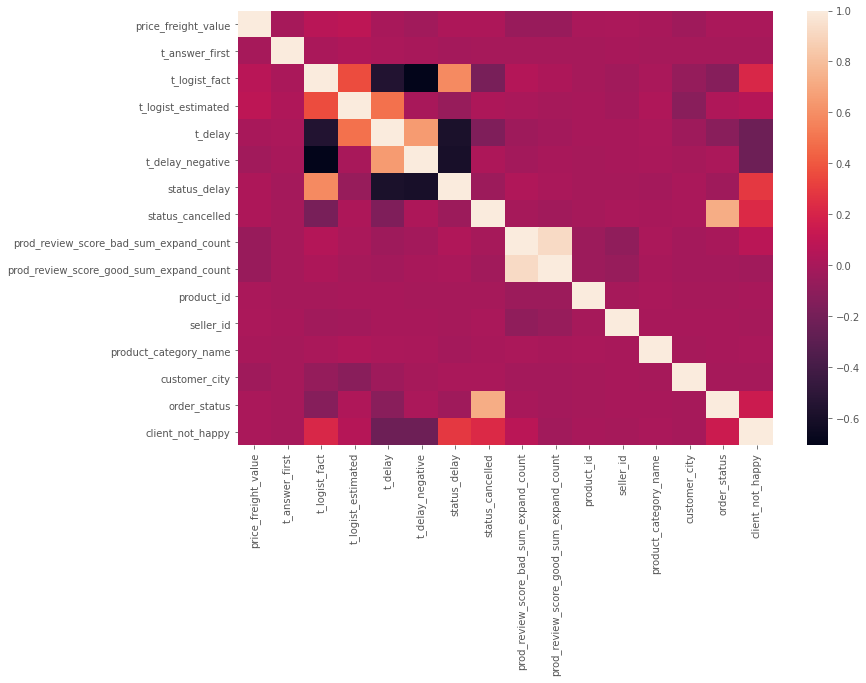

In [182]:
feats=['price_freight_value', 't_answer_first', 
       't_logist_fact', 't_logist_estimated', 't_delay', 't_delay_negative', 'status_delay', 'status_cancelled', # это показатели логистики, опоздания и отмены заказа
       'prod_review_score_bad_sum_expand_count', 'prod_review_score_good_sum_expand_count', # показатели оценок на момент заказа - это формирование ожиданий клиента
       'product_id', 'seller_id', 'product_category_name', 'customer_city','order_status',
      'client_not_happy']

corr_matrix = df102[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

### Вариант 2. Удалили часть высококоррелированных между собой фич и оставили минимальный набор

Метрики модели существенно ухудшились, доля 1ой группы выросла до 70% от всех фактически недовольных клиентов. Т.е. неучет накопленной оценки продукта (хороших и плохих оценок) резко снижает точность модели.



4it [00:07,  1.98s/it]


0.8560230782430915


Weight,Feature
0.4147,t_delay
0.3499,order_status
0.0571,t_answer_first
0.0396,t_logist_estimated
0.0383,product_category_name
0.0319,seller_id
0.0264,price_freight_value
0.0211,product_id
0.0210,customer_city


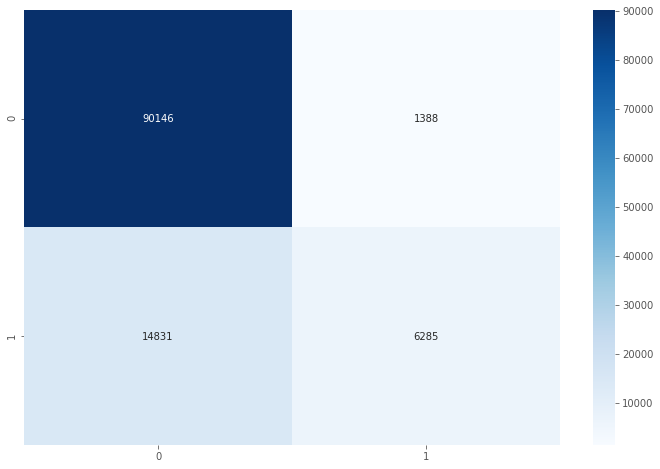

In [188]:
feats=['price_freight_value', 't_answer_first', 
        't_logist_estimated', 't_delay',   # это показатели логистики, опоздания и отмены заказа
       #'prod_review_score_bad_sum_expand_count', 'prod_review_score_good_sum_expand_count',
       'product_id', 'seller_id', 'product_category_name', 'customer_city','order_status']

col_label='client_not_happy' # определяем удовлетворен или нет клиент в итоге
check_log_model_class(df102, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

---------------------  ---------------------  ----------
t_delay                t_logist_estimated     0.492547
client_not_happy       t_delay                0.232943
client_not_happy       order_status           0.150031
customer_city          t_logist_estimated     0.115377
order_status           t_delay                0.114479
t_logist_estimated     price_freight_value    0.0915004
client_not_happy       t_logist_estimated     0.0568498
customer_city          t_delay                0.0349616
order_status           t_logist_estimated     0.0325194
product_category_name  t_logist_estimated     0.0284012
customer_city          price_freight_value    0.0272638
t_logist_estimated     t_answer_first         0.0272034
seller_id              price_freight_value    0.0170806
product_category_name  t_delay                0.0167085
t_delay                t_answer_first         0.016157
seller_id              t_logist_estimated     0.0158149
client_not_happy       price_freight_value    0.01229

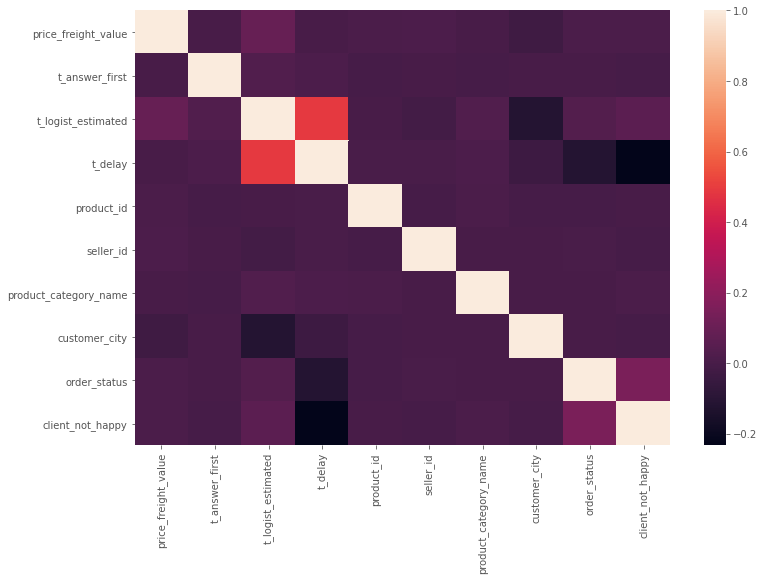

In [184]:
feats=['price_freight_value', 't_answer_first', 
       't_logist_estimated', 't_delay',  # это показатели логистики, опоздания и отмены заказа
      # 'prod_review_score_bad_sum_expand_count', 'prod_review_score_good_sum_expand_count', # показатели оценок на момент заказа - это формирование ожиданий клиента
       'product_id', 'seller_id', 'product_category_name', 'customer_city','order_status',
      'client_not_happy']

corr_matrix = df102[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

### Вариант 3. Расширяем набор фич, доступных маркетплейсу на момент выполнения заказа, так как это он прогнозирует удовлетворенность клиента

Эта модель уже лучше. Доля первой группы снизилась до 31% от всех фактически недовольных клиентов.

4it [00:18,  4.74s/it]


0.9257967247657116


Weight,Feature
0.4108,prod_review_score_bad_sum_expand_rate2
0.1096,prod_client_not_happy_sum_expand_count
0.0967,t_review_create_estimated
0.0790,prod_review_score_good_sum_expand_count
0.0449,prod_review_score_sum_expand_mean
0.0365,product_days_in_sales_before
0.0340,status_cancelled
0.0272,prod_review_message_is_bad_sum_expand_rate
0.0226,t_review_create_delivered
0.0201,num_uniq_prod


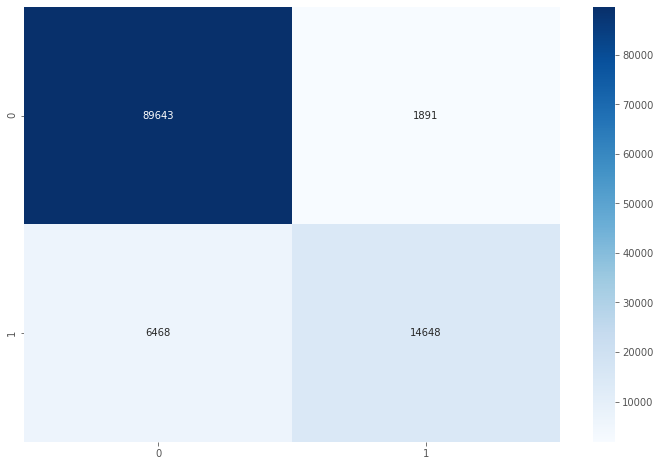

In [187]:
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_rate',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status']

col_label='client_not_happy' # определяем удовлетворен или нет клиент в итоге
check_log_model_class(df102, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

-------------------------------------------  -------------------------------------------  --------
prod_review_score_good_sum_expand_count      prod_review_score_sum_expand_sum             0.999157
prod_review_score_count_expand_count         prod_review_score_sum_expand_sum             0.998494
prod_review_score_good_sum_expand_count      prod_review_score_count_expand_count         0.995972
prod_client_not_happy_sum_expand_count       prod_review_score_bad_sum_expand_count       0.993332
prod_price_freight_value_sum_expand_mean     prod_price_freight_value_sum_expand_sum      0.989096
prod_review_message_is_sum_expand_count      prod_review_score_count_expand_count         0.985759
prod_client_not_happy_sum_expand_count       prod_review_message_is_bad_sum_expand_count  0.981214
prod_review_message_is_sum_expand_count      prod_review_score_sum_expand_sum             0.980969
prod_review_message_is_sum_expand_count      prod_review_score_good_sum_expand_count      0.976619
prod_revie

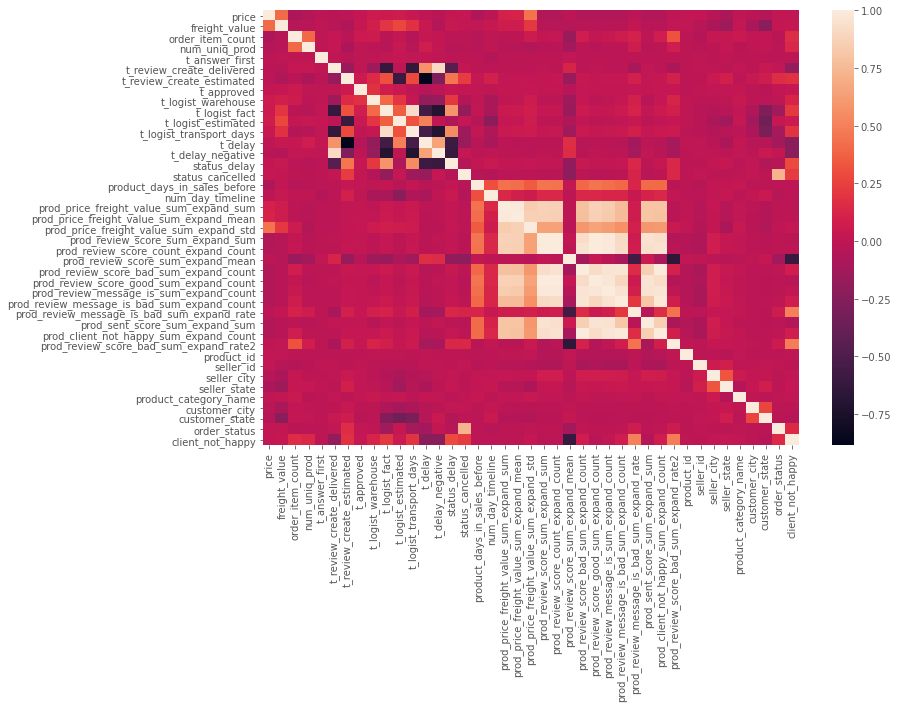

In [198]:
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_rate',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status', 'client_not_happy']

corr_matrix = df102[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

#### Вариант 3.1. Подбираем гиперпараметры для модели из 3го варианта

4it [00:19,  4.78s/it]
(0.9257967247657116, array([[89643,  1891],
       [ 6468, 14648]]))
5 -- 50 -- <IPython.core.display.HTML object>
4it [00:36,  9.12s/it]
(0.9286728870429262, array([[89657,  1877],
       [ 6158, 14958]]))
5 -- 100 -- <IPython.core.display.HTML object>
4it [01:11, 17.95s/it]
(0.9304305529577842, array([[89594,  1940],
       [ 5897, 15219]]))
5 -- 200 -- <IPython.core.display.HTML object>
4it [02:57, 44.33s/it]
(0.9334664990336987, array([[89479,  2055],
       [ 5440, 15676]]))
5 -- 500 -- <IPython.core.display.HTML object>
4it [05:59, 89.82s/it]
(0.9340168775694502, array([[89380,  2154],
       [ 5279, 15837]]))
5 -- 1000 -- <IPython.core.display.HTML object>

4it [01:43, 25.92s/it]
(0.9338304646611401, array([[89536,  1998],
       [ 5456, 15660]]))
7 -- 200 -- <IPython.core.display.HTML object>
4it [02:23, 35.93s/it]
(0.9366444883566265, array([[89698,  1836],
       [ 5301, 15815]]))
9 -- 200 -- <IPython.core.display.HTML object>
4it [03:06, 46.63s/it]
(0.9362894008852355, array([[89697,  1837],
       [ 5340, 15776]]))
11 -- 200 -- <IPython.core.display.HTML object>
4it [05:48, 87.08s/it]
(0.9359076931300658, array([[89655,  1879],
       [ 5341, 15775]]))
9 -- 500 -- <IPython.core.display.HTML object>

4it [00:19,  4.89s/it]


(0.9257967247657116, array([[89643,  1891],
       [ 6468, 14648]]))
5 -- 50 -- <IPython.core.display.HTML object>


4it [00:36,  9.15s/it]


(0.9286728870429262, array([[89657,  1877],
       [ 6158, 14958]]))
5 -- 100 -- <IPython.core.display.HTML object>


4it [00:26,  6.69s/it]


(0.9285841139930474, array([[89700,  1834],
       [ 6211, 14905]]))
7 -- 50 -- <IPython.core.display.HTML object>


4it [00:53, 13.31s/it]


(0.9311495943939105, array([[89612,  1922],
       [ 5834, 15282]]))
7 -- 100 -- <IPython.core.display.HTML object>


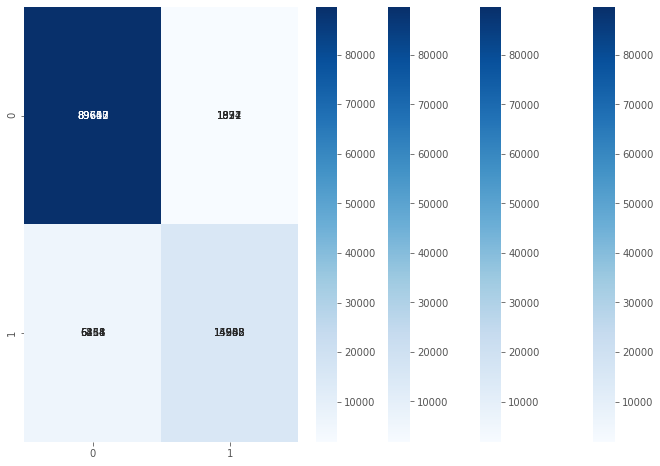

In [195]:
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_rate',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status']


col_label='client_not_happy' # определяем удовлетворен или нет клиент в итоге

for itemdepth in [5,7]:
    for itemestim in [50,100]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model_class(df102, feats, col_label, xgb.XGBClassifier(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)
        


### Вариант 4. Финальный.

**ВЫВОД:**
- Эта модель уже лучше. После подбора нескольких гиперпараметров модели доля первой группы снизилась до 25% от всех фактически недовольных клиентов. Т.е.мы сократили количество клиентов, по которым можем опоздать предпринять соответствующие действия.
- основные факторы модели (по каждому продукту): количество недовольных клиентов с момента начала продаж продукта, отношение суммарного количества плохих оценок (1,2) к хорошим (4,5), количество хороших оценок, отмена заказа/
- вопреки ожиданиям, нарушение сроков доставки не является определяющим фактором оценки. Относительно высокая корреляция между нарушением сроков и оценкой появляется только если рассматривать чисто логистические показатели, но при этом модель на этом наборе показателей работает плохо, что говорит о наличии более важных факторов, чем доставка. И как мы видим в текущей модели - это превалирование плохих оценок над хорошими и др.

4it [05:57, 89.43s/it]


(0.9340168775694502, array([[89380,  2154],
       [ 5279, 15837]]))


Weight,Feature
0.2266,prod_client_not_happy_sum_expand_count
0.2073,prod_review_score_bad_sum_expand_rate2
0.0768,prod_review_score_good_sum_expand_count
0.0519,status_cancelled
0.0519,t_review_create_estimated
0.0503,order_item_count
0.0436,num_uniq_prod
0.0283,prod_review_score_sum_expand_mean
0.0248,t_review_create_delivered
0.0192,product_days_in_sales_before


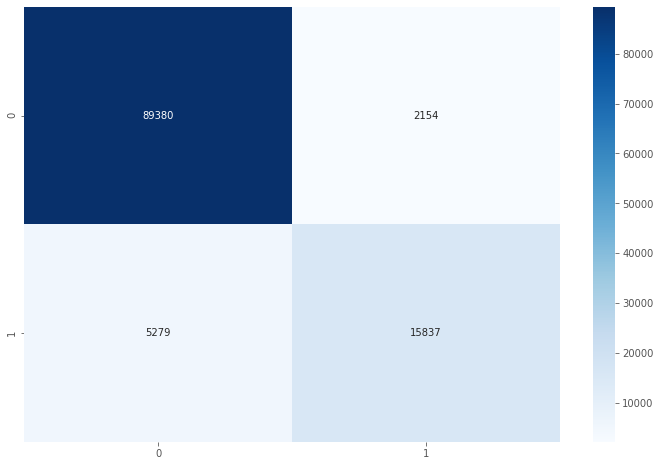

In [197]:
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_rate',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status']

col_label='client_not_happy' # определяем удовлетворен или нет клиент в итоге
check_log_model_class(df102, feats, col_label, xgb.XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.3, random_state=0))

-------------------------------------------  -------------------------------------------  --------
prod_review_score_good_sum_expand_count      prod_review_score_sum_expand_sum             0.999157
prod_review_score_count_expand_count         prod_review_score_sum_expand_sum             0.998494
prod_review_score_good_sum_expand_count      prod_review_score_count_expand_count         0.995972
prod_client_not_happy_sum_expand_count       prod_review_score_bad_sum_expand_count       0.993332
prod_price_freight_value_sum_expand_mean     prod_price_freight_value_sum_expand_sum      0.989096
prod_review_message_is_sum_expand_count      prod_review_score_count_expand_count         0.985759
prod_client_not_happy_sum_expand_count       prod_review_message_is_bad_sum_expand_count  0.981214
prod_review_message_is_sum_expand_count      prod_review_score_sum_expand_sum             0.980969
prod_review_message_is_sum_expand_count      prod_review_score_good_sum_expand_count      0.976619
prod_revie

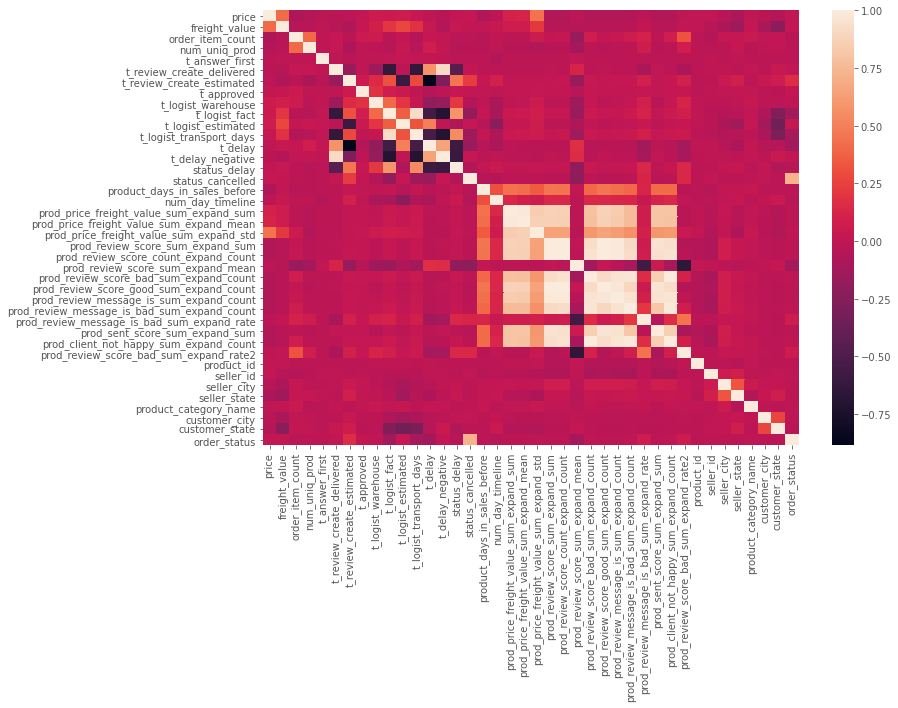

In [196]:
feats=['price', 'freight_value', 'order_item_count', 'num_uniq_prod',
       't_answer_first', 't_review_create_delivered', 't_review_create_estimated', 't_approved',
       't_logist_warehouse', 't_logist_fact', 't_logist_estimated',
       't_logist_transport_days', 't_delay','t_delay_negative', 'status_delay', 'status_cancelled',
       'product_days_in_sales_before',
       'num_day_timeline', 'prod_price_freight_value_sum_expand_sum',
       'prod_price_freight_value_sum_expand_mean',
       'prod_price_freight_value_sum_expand_std', 'prod_review_score_sum_expand_sum',
       'prod_review_score_count_expand_count',
       'prod_review_score_sum_expand_mean',
       'prod_review_score_bad_sum_expand_count',
       'prod_review_score_good_sum_expand_count',
       'prod_review_message_is_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_count',
       'prod_review_message_is_bad_sum_expand_rate',
       'prod_sent_score_sum_expand_sum',
       'prod_client_not_happy_sum_expand_count',
       'prod_review_score_bad_sum_expand_rate2', 
       'product_id', 'seller_id', 'seller_city',
       'seller_state', 'product_category_name', 'customer_city',
       'customer_state', 'order_status','client_not_happy']

corr_matrix = df102[feats].corr(method='pearson')
sns.heatmap(corr_matrix);

ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
print(tabulate(correlations90))

In [654]:
# наборы строк для корреляционной матрицы
cor_log=col_time+col_review
cor_log2=[ 't_delay',  'status_cancelled','review_score', 'sent_score', 'sent_magnitude','t_answer_first']

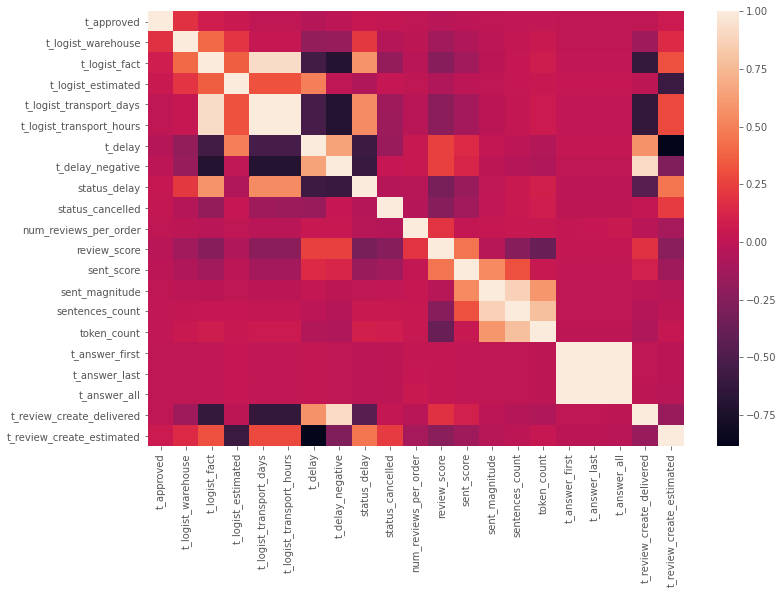

In [655]:
# Calculate and plot
corr_matrix = df102[cor_log].corr()
sns.heatmap(corr_matrix);

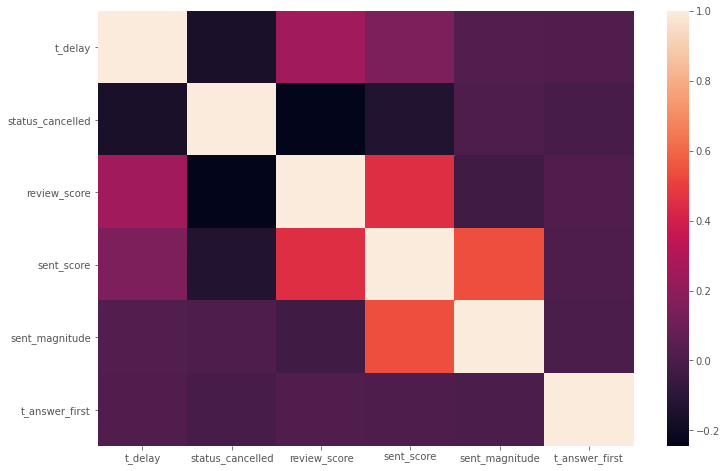

In [656]:
corr_matrix = df102[cor_log2].corr(method='pearson')
sns.heatmap(corr_matrix);

In [658]:
ddf = corr_matrix # таблица корреляции
ddf['col1']=ddf.index # новый столбец с наименованием индекса
ddf = ddf.melt(id_vars=['col1']) # разворачиваем таблицу
ddf['value']=abs(ddf['value']).drop_duplicates() # приводим к абсолютным значениям и удаляем дубликаты
correlations90 = ddf[ddf['value'] !=1].sort_values(by=['value'], ascending=(False))[['col1','variable','value']].head(20).values.tolist()
correlations90

[['sent_magnitude', 'sent_score', 0.5407004288518964],
 ['sent_score', 'review_score', 0.45206343983440067],
 ['review_score', 't_delay', 0.2562159529707183],
 ['review_score', 'status_cancelled', 0.24436146893931615],
 ['status_cancelled', 't_delay', 0.15695835435200622],
 ['sent_score', 't_delay', 0.15189723403005845],
 ['sent_score', 'status_cancelled', 0.12912369523016343],
 ['sent_magnitude', 'review_score', 0.031437539812070175],
 ['sent_magnitude', 't_delay', 0.019210838488607364],
 ['t_answer_first', 'review_score', 0.016978284957797865],
 ['t_answer_first', 't_delay', 0.01615696575574927],
 ['sent_magnitude', 'status_cancelled', 0.012796510645290908],
 ['t_answer_first', 'sent_score', 0.009688169384613038],
 ['t_answer_first', 'status_cancelled', 0.00638533765756576],
 ['t_answer_first', 'sent_magnitude', 0.001246217889212692],
 ['t_delay', 'status_cancelled', nan],
 ['status_cancelled', 'status_cancelled', nan],
 ['t_delay', 'review_score', nan],
 ['status_cancelled', 'review

# Диграммы

In [257]:
df_total.head(2)

,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_geo_lat,sellers_geo_lng,mql_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp_x,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_geo_lat,customers_geo_lng,order_item_count,sum_price,sum_freight_value,sum_price_freight,num_uniq_prod,num_reviews_per_order,min_review_create_date,max_review_create_date,min_review_answer_date,max_review_answer_date,review_id,review_score,sent_score,sent_magnitude,sentences_count,token_count,first_contact_date,landing_page_id,origin,order_datetime,timeline,order_purchase_timestamp_y,price_sum,price_freight_value_sum,review_score_sum,review_score_count,review_score_bad_sum,review_score_good_sum,review_message_is_sum,client_not_happy_sum,review_message_is_bad_sum,sent_score_sum,product_days_in_sales_before,product_days_in_sales_after,prod_price_sum_sum,prod_price_sum_mean,prod_price_sum_std,prod_price_sum_rol_sum,prod_price_sum_rol_mean,prod_price_sum_rol_std,prod_price_sum_rol_count,prod_price_sum_expand_sum,prod_price_sum_expand_mean,prod_price_sum_expand_std,num_day_timeline,prod_price_freight_value_sum_sum,prod_price_freight_value_sum_mean,prod_price_freight_value_sum_std,prod_price_freight_value_sum_rol_sum,prod_price_freight_value_sum_rol_mean,prod_price_freight_value_sum_rol_std,prod_price_freight_value_sum_rol_count,prod_price_freight_value_sum_expand_sum,prod_price_freight_value_sum_expand_mean,prod_price_freight_value_sum_expand_std,prod_review_score_sum_sum,prod_review_score_sum_mean,prod_review_score_sum_expand_sum,prod_review_score_count_expand_count,prod_review_score_sum_expand_mean,prod_review_score_bad_sum_count,prod_review_score_good_sum_count,prod_review_score_bad_sum_expand_count,prod_review_score_good_sum_expand_count,prod_review_score_bad_sum_expand_rate,prod_review_message_is_sum_count,prod_review_message_is_bad_sum_count,prod_sent_score_sum_sum,prod_client_not_happy_sum_count,prod_review_message_is_sum_expand_count,prod_review_message_is_bad_sum_expand_count,prod_review_message_is_bad_sum_expand_rate,prod_sent_score_sum_expand_sum,prod_client_not_happy_sum_expand_count,prod_review_score_bad_sum_expand_rate2
0,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.00,17.87,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.262584,-46.171124,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870305,-44.593326,1.0,199.00,17.87,216.87,1.0,1.0,2018-01-23 00:00:00,2018-01-23 00:00:00,2018-01-23 16:06:31,2018-01-23 16:06:31,0c5b33dea94867d1ac402749e5438e8b,5.0,0.9,1.9,2.0,15.0,0,0,0,2018-01-14,2018-01-14,2018-01-14 00:00:00,199.00,216.87,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.9,76.0,0.0,597.00,199.00,0.0,199.00,14.214286,53.184987,14.0,597.00,0.801342,12.611044,745.0,652.82,217.606667,1.275944,216.87,15.490714,57.960946,14.0,652.82,0.876268,13.790346,13.0,4.333333,13.0,3.0,4.333333,0,3,0.0,3.0,0.0,3,0,2.6,0,3.0,0.0,0.0,2.6,0.0,0.0
1,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,2018-08-15 10:10:18,12.99,12.79,9d7a1d34a5052409006425275ba1c2b4,14403,franca,SP,-20.553624,-47.387359,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,d4eb9395c8c0431ee92fce09860c5a06,de

In [255]:
list(df_total.columns)

['order_id',
 'order_item_id',
 'product_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'seller_id',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'sellers_geo_lat',
 'sellers_geo_lng',
 'mql_id',
 'sdr_id',
 'sr_id',
 'won_date',
 'business_segment',
 'lead_type',
 'lead_behaviour_profile',
 'has_company',
 'has_gtin',
 'average_stock',
 'business_type',
 'declared_product_catalog_size',
 'declared_monthly_revenue',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_id',
 'order_status',
 'order_purchase_timestamp_x',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customers_geo_lat',
 'customers_geo_lng',
 'order_item_count',
 'sum_price',
 'sum_fr

## Barplot (рейтинги)

In [210]:
def viz_barplot(pp):
    df1=eval(pp[0]).groupby([pp[1]]).agg({pp[2]:pp[3]}).reset_index().sort_values(by=pp[2], ascending=False)
    print(df1.head(4))
    plt.xticks(rotation=90)
    sns.barplot(x=pp[1], y=pp[2], data=df1.head(pp[4]))

In [263]:
def viz_barplot_asc(pp):
    df1=eval(pp[0]).groupby([pp[1]]).agg({pp[2]:pp[3]}).reset_index().sort_values(by=pp[2], ascending=True)
    print(df1.head(4))
    plt.xticks(rotation=90)
    sns.barplot(x=pp[1], y=pp[2], data=df1.head(pp[4]))

### ТОП-25 продуктов с хорошими оценками (5,4)

                             product_id  review_score_good_sum
22112  aca2eb7d00ea1a7b8ebd4e68314663af                 1909.0
10867  53b36df67ebb7c41585e8d54d6772e08                 1905.0
8613   422879e10f46682990de24d770e7f83d                 1745.0
7079   368c6c730842d78016ad823897a372db                 1114.0


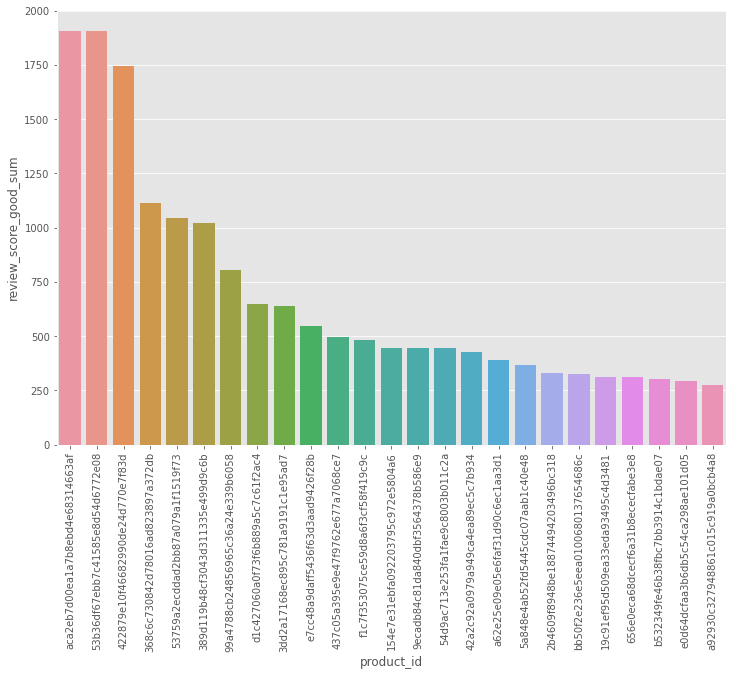

In [258]:
viz_barplot(['df_total','product_id','review_score_good_sum','sum',25])

### ТОП-25 продуктов с плохими оценками (1,2)

                             product_id  review_score_bad_sum
8613   422879e10f46682990de24d770e7f83d                 698.0
30667  ee3d532c8a438679776d222e997606b3                 445.0
10840  53759a2ecddad2bb87a079a1f1519f73                 387.0
7079   368c6c730842d78016ad823897a372db                 367.0


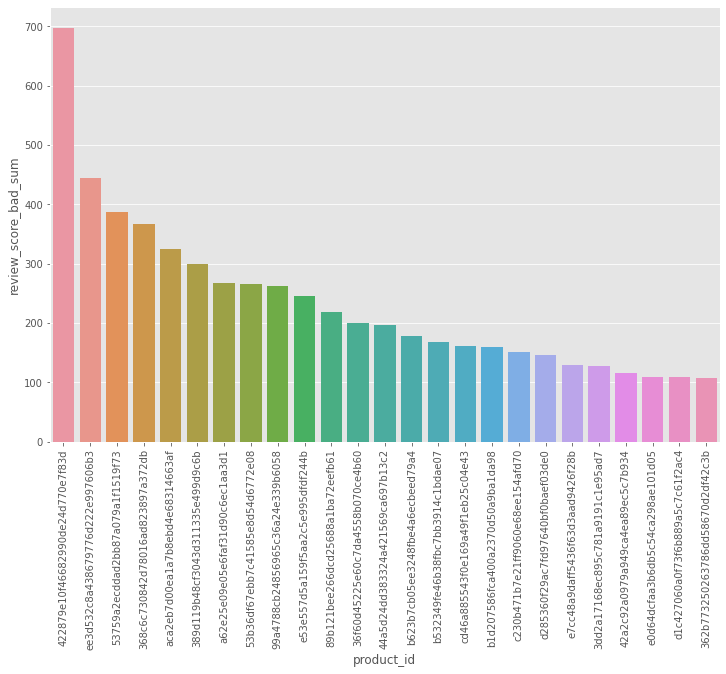

In [259]:
viz_barplot(['df_total','product_id','review_score_bad_sum','sum',25])

### ТОП-25 пользователей по количеству текстовых отзывов

                     customer_unique_id  review_message_is_sum
25885  4546caea018ad8c692964e3382debd19                  201.0
92455  f7ea4eef770a388bd5b225acfc546604                  196.0
43897  7582a5a77fc2976628f46a13ec91b375                  169.0
59256  9eca552063680b7cd2ed0e8aea002b21                  144.0


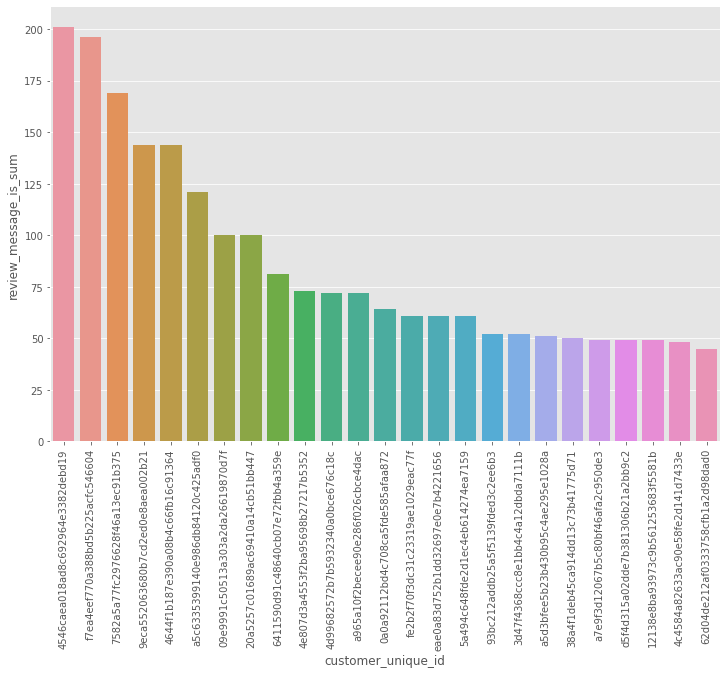

In [262]:
viz_barplot(['df_total','customer_unique_id','review_message_is_sum','sum',25])

### ТОП-25 пользователей с максимально положительной суммой тональностей текстовых отзывов (позитивисты)

                     customer_unique_id  sent_score_sum
66814  b2e9a05d23ea17713b5d7799f2004f8e       36.899999
82888  de083d6adb27920ff993b75eac74be01       32.399999
79051  d39ca7f15bf72b7010ec9f965ab138e6       32.399999
38305  66687f241e65be2fc37e4213aebd2d76       32.399999


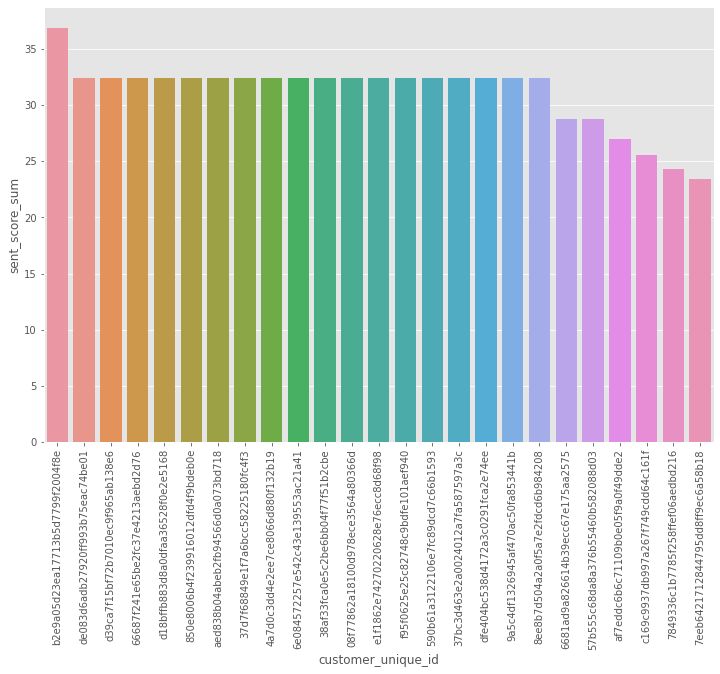

In [264]:
viz_barplot(['df_total','customer_unique_id','sent_score_sum','sum',25])

### ТОП-25 пользователей с максимально отрицательной суммой тональностей текстовых отзывов (негативисты)

                     customer_unique_id  sent_score_sum
25885  4546caea018ad8c692964e3382debd19     -140.699998
3744   09e9991c50513a303a2da26619870d7f      -69.999999
37413  6411590d91c48640cb07e72fbb4a359e      -64.800001
12224  20a5257c01689ac69410a14cb51bb447      -50.000000


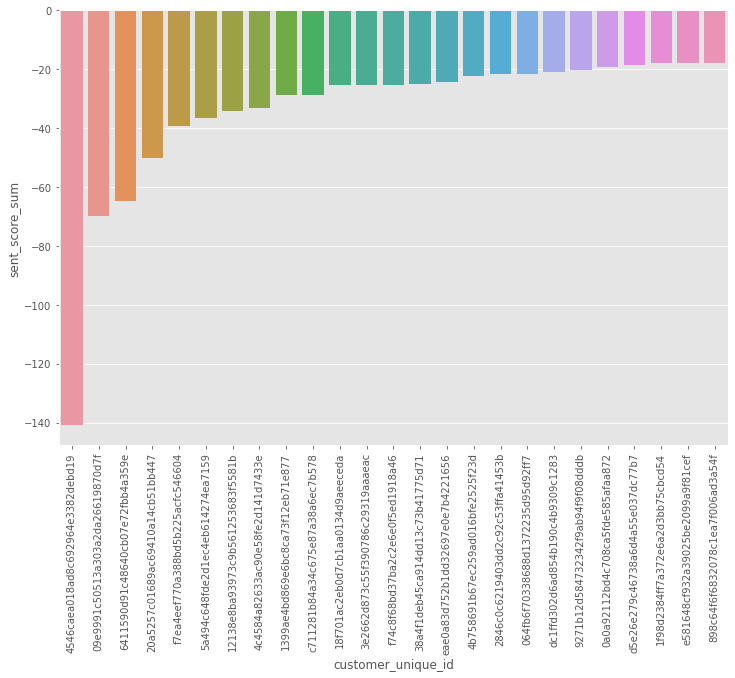

In [265]:
viz_barplot_asc(['df_total','customer_unique_id','sent_score_sum','sum',25])

### ТОП-25 продавцов с хорошими оценками (5,4)

                             seller_id  review_score_good_sum
368   1f50f920176fa81dab994f9023523100                 5394.0
1824  955fee9216a65b617aa5c0531780ce60                 3395.0
192   1025f0e2d44d7041d6cf58b6550e0bfa                 2490.0
2481  cc419e0650a3c5ba77189a1882b7556a                 2202.0


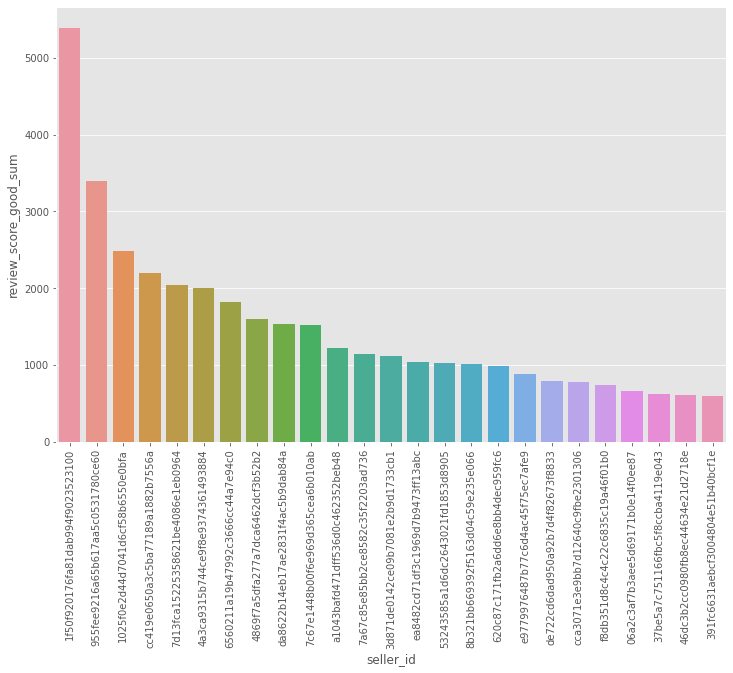

In [260]:
viz_barplot(['df_total','seller_id','review_score_good_sum','sum',25])

### ТОП-25 продавцов с плохими оценками (1,2)

                             seller_id  review_score_bad_sum
368   1f50f920176fa81dab994f9023523100                1829.0
1535  7c67e1448b00f6e969d365cea6b010ab                 988.0
192   1025f0e2d44d7041d6cf58b6550e0bfa                 759.0
1824  955fee9216a65b617aa5c0531780ce60                 751.0


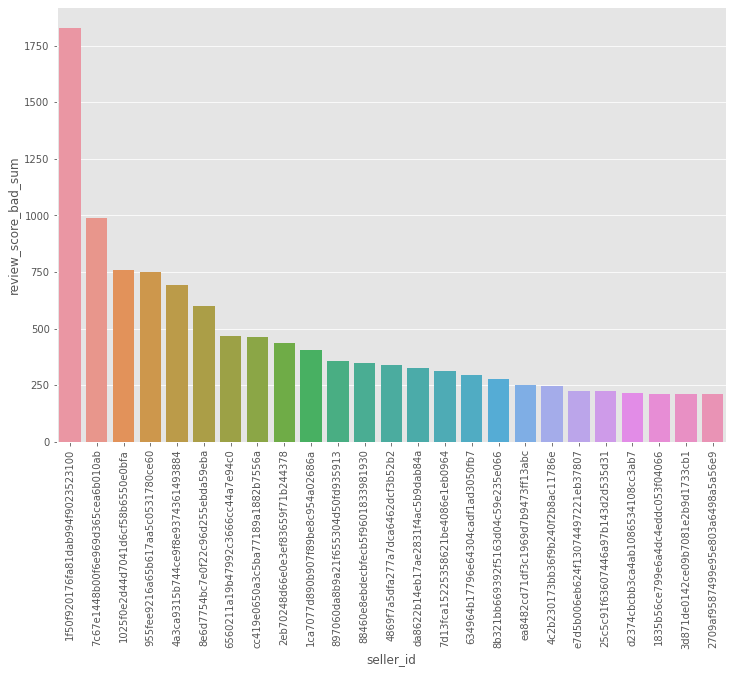

In [261]:
viz_barplot(['df_total','seller_id','review_score_bad_sum','sum',25])

### ТОП-25 регионов с максимальной долей неудовлетворенных клиентов

  customer_state  client_not_happy_sum  order_item_count  not_happy_rate
0             AC                  23.0             138.0            16.7
1             AL                 177.0             540.0            32.8
2             AM                  62.0             225.0            27.6
3             AP                  14.0             124.0            11.3


<AxesSubplot:xlabel='customer_state', ylabel='not_happy_rate'>

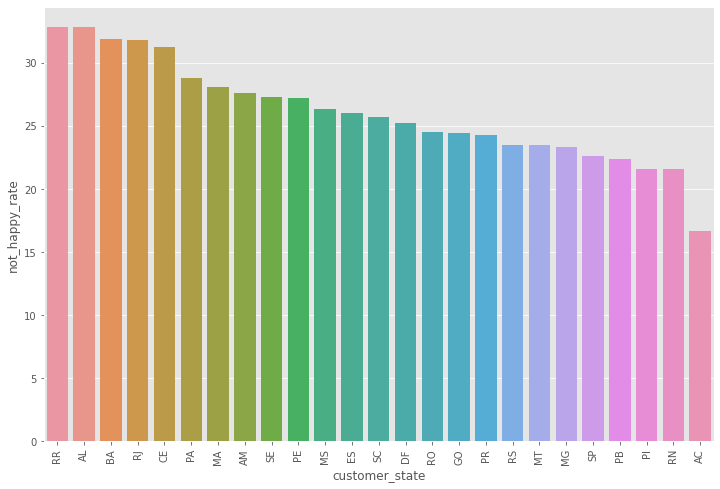

In [274]:
df1=df_total.groupby('customer_state').agg({'client_not_happy_sum':'sum','order_item_count':'sum'}).reset_index()#.sort_values(by=pp[2], ascending=False)
df1['not_happy_rate']=round(df1['client_not_happy_sum']/df1['order_item_count']*100,1)
print(df1.head(4))
plt.xticks(rotation=90)
sns.barplot(x='customer_state', y='not_happy_rate', data=df1.sort_values(by='not_happy_rate', ascending=False).head(25))


## Countplot (рейтинги)

In [275]:
def viz_countplot(pp):
    df1=eval(pp[0])
    sns.countplot(x=pp[1], hue=pp[2], data=df1)

#### Распределение оценок у довольных и недовольных клиентов

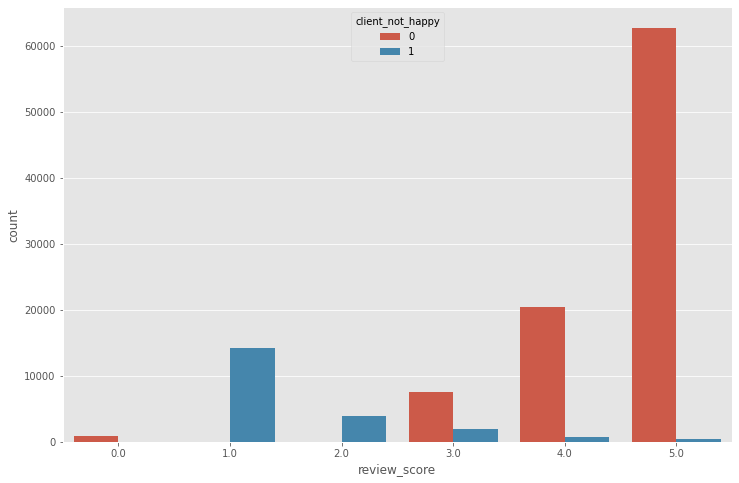

In [276]:
viz_countplot(['df102','review_score','client_not_happy'])


# Итоги и выводы

**1. Анализ** начат с описания бизнеса и выявления бизнес-задач (более подробно см.в соответствующем разделе ноутбука выше). Анализ бизнеса и имеющей информации показал:
- **для более полного анализа и разработки более точных моделей хотелось бы иметь еще следующую информацию:** история покупок клиента на других маркетплейса; периодические опросы клиентов, выявляющие механизм возникновения потребности и выбор данного маркетплейса; история логов покупателя при нахождении на сайте, в т.ч.откуда пришел на страницу; история рекламных активностей на сайте; история повторных заходов на сайт ДО совершения заказа (мы не можем понять сколько времени требуется на обдумывание покупки, каков процесс принятия решения); нет истории просмотра товаров для сравнительного анализа: на основании этой истории мы могли бы составлять ограниченные массивы сравниваемых товаров и анализировать матрицу предпочтений именно на этой выборке; в датасете нет информации об уходе с сайта после изучения товаров, а также информации о "брошенных корзинах" на этапе оформления; Обычно дается выбор между доставкой клиенту и самовывозом - в этом датасете такой категории нет; также должны быть покупки вообще без оценок, т.е. клиент не ответил на опрос, а их практически нет - почему? или в этом случае система сама автоматически ставит оценку, что заставляет клиента отвечать на опросы удовлетворенности?
- **ключевые направления по разработке дополнительных фич были:** 1) разработка агрегированных показателей с использованием оконных функций на дату заказа (брал скользящее фиксированное окно в 14 календарных дней и нарастающим итогом с начала продаж продукта); 2) обработка текстовых отзывов с использование Google Natural language api и использование рассчитанной тональности вместе с числовой оценкой для классификации клиентов на удовлетворенных и неудовлетворенных.

**2. Задачи машинного обучения:**
- **разработанные модели показали, что в имеющемся датасете достаточно данных, чтобы прогнозировать отдельные показатели, но дополнительная информация могла бы дать новые фичи**

**2.1. Задача регрессии**

**"Оценить вероятность возврата клиента"**
- Эта задача дает ответ на вопросы: "Какие товары получают больше всего высоких оценок, а какие - больше всего низких? Можно ли с помощью имеющихся данных понять почему? Есть ли связь между оценками и продажами? Например, оцените вероятность возвращения клиента после высокой оценки и после низкой. Что будет со средним чеком?"
- Так как в базе очень мало записей с повторными заказами по одному клиенту, то преобразуем задачу в **Оценить вероятность выбора конкретного продукта новым клиентом**.
- в данном случае показатель среднего чека не использую, так как в заказах преобладают заказы с одной позицией и нет потенциала увеличивать именно стоимость заказа в среднем. Но есть потенциал увеличения количества заказов за определенный промежуток времени, который напрямую влияет на среднедневные продажи.
- Гипотеза: товары, которые по совокупности наблюдаемых клиентом характеристик, в его глазах более предпочтительны, должны лучше продаваться и следовательно продажи после данного заказа должны быть лучше, чем до заказа. И наоборот.
- Для ее оценки будем использовать **"Среднедневная сумма продаж в период от даты совершения заказа до последней даты продажи этого товара** 
- из датасета удаляю продукты, которые ИЛИ 1)продались только один раз за все время (по ним нет никакой статистически значимой истории); 2) первая продажа товара (так как среднедневные продажи до ее совершения невозможно рассчитать); 3) последняя продажа товара (так как среднедневные продажи после нее невозможно рассчитать). (Конечно, датасет сократился почти в 2 раза, но строки без прогнозного значения создали бы лишний шум для модели регрессии. При необходимости, можно сделать кластерный анализ, чтобы понять, чем например продукты, проданные только один раз, отличаются от других продуктов).

***2.1.1.Итоги задачи регрессии:***
- оставили только минимальный набор фич. 
- итоговая оценка MAE (6.8170358896071, 0.34776008902710026) - эта ошибка почти в 5 раз ниже, чем вычисление трендов по средней или медиане.
- Цена продукта и количество хороших оценок (4,5) по нему оказывают основное влияние на прогнозируемые среднедневные продажи.
- Другие важные факторы: количество плохих оценок (1,2) и стоимость доставки
- при очень ограниченном количестве фич модель не намного хуже, чем моделирование на полных исторических данных

**2.2. Задача классификации:**

**"Спрогнозировать удовлетворенность клиента"**
- Эта задача дает ответ на вопросы: "Есть ли связь оценок и сроков доставки заказов? Может быть вы хотите обратить внимание на что-нибудь еще?"
- В данном случае Неудовлетворенным клиентом будем считать того, кто либо поставил плохую оценку (1,2), либо написал текстовой отзыв с отрицательной тональностью, либо и то, и другое. Так как ряд заказов содержал несколько оценок, то брались данные по последнему отзыву, как финальная удовлетворенность клиента.
- Гипотеза: если какие-то параметры взаимодействия клиента с маркетплейсом в процессе заказа товара и его фактического получения, а также его потребительский опыт в отношении полученного продукта существенно отклонились от ожиданий, то с высокой вероятностью клиент на это отгреагирует плохими оценками и комментариями.
- датасет будем использовать весь, без урезания, как в задаче регрессии, так как мы прогнозируем результат каждой сделки
- также изучали несколько вариантов набора фич:
**Вариант 1. Набор фич включает логистику, товар, поставщика и оценки товара на маркетплейсе**
- взяли как базовый.
- Для данной задачи классификации мы имеем 4 квадранта по степени убывания важности для предпринятия действий маркетплейсом:
1. (8869) - фактически недовольный клиент, но модель их НЕ предсказала. И это (8869/21116=42%) 42% недовольных клиентов, которые маркетплейс пропустит мимо, и они оставят негативные отметки на сайте, ухудшая продажи. Т.е. это самая важная категория клиентов, с которой надо предпринимать оперативные действия ДО момент оставления ими отзыва.
2. (12247) - фактически недовольные клиенты и модель их предсказала. Это тоже группа с которой надо работать маркетплейсу, но так как модель их предсказала правильно, то нет аврала.
3. (1612) - фактически довольные клиенты, но модель посчитала их недовольными. Есть конечно риск, что при звонке от маркетплейса в уверенности что это недовольный клиент, можно ухудшить удовлетворенность. Но если сценарий беседы с клиентом выстраивать правильно, то все закончится еще на первой стадии разговора и прояснении ситуации.
4. (89922) - фактически довольные клиенты, и модель их правильно предсказала. Здесь маркетплейсу не требуется предпринимать активных действий.
- В итоге нам в данной задаче необходимости выбрать модель, которая выдает наименьшее количество клиентов в 1 группе и наибольшее во 2ой
- Вариант1 оказался не очень - только 58% неудовлетворенных клиентов смогла выявить.

**Вариант 2. Удалили часть высококоррелированных между собой фич и оставили минимальный набор**
- Метрики модели существенно ухудшились, доля 1ой группы выросла до 70% от всех фактически недовольных клиентов. Т.е. неучет накопленной оценки продукта (хороших и плохих оценок) резко снижает точность модели.
**Вариант 3. Расширяем набор фич, доступных маркетплейсу на момент выполнения заказа, так как это он прогнозирует удовлетворенность клиента**
- Эта модель уже лучше. Доля первой группы снизилась до 31% от всех фактически недовольных клиентов.
**Вариант 4. Финальный, после подбора гиперпараметров**
- Эта модель уже лучше. После подбора нескольких гиперпараметров модели доля первой группы снизилась до 25% от всех фактически недовольных клиентов. Т.е.мы сократили количество клиентов, по которым можем опоздать предпринять соответствующие действия.

***2.2.1.Итоги задачи классификации:***
- основные факторы модели (по каждому продукту): количество недовольных клиентов с момента начала продаж продукта, отношение суммарного количества плохих оценок (1,2) к хорошим (4,5), количество хороших оценок, отмена заказа/
- вопреки ожиданиям, нарушение сроков доставки не является определяющим фактором оценки. Относительно высокая корреляция между нарушением сроков и оценкой появляется только если рассматривать чисто логистические показатели, но при этом модель на этом наборе показателей работает плохо, что говорит о наличии более важных факторов, чем доставка. И как мы видим в текущей модели - это превалирование плохих оценок над хорошими и др.
- но так как модель еще не показывает достаточно хороший результат, значит необходимо искать другие факторы, которые для клиента столь же важны или даже более.